# Advanced Analytics - Sports Wear Group

## Contents 

1) Importing needed libraries
2) Loading data into Pandas
3) Data Understanding, Problems and Solutions
4) Exploratory Data Analysis (whole data)
    - Nulls
    - Outliers
    - Class Imbalance 
    - Correlation and relevant features selection
5) Creating new dataset with relevant features
    - handling duplicated rows with different labels.
    - handling class imbalance.
   <br> *(using Majority Vote)*
6) Exploratory Data Analysis (cleaned and processed data)
    - Feature Engineering
    - Analysis
        - Relations with Target
        - Relations between features
        - Relations Across time
7) Questions and Insights
8) Benefits to business and recommendations summary
9) Preprocessing 
    - Checking Multicollinearity
    - Features selection
    - Data transformations
    - Categorical Encoding
    - SMOTE for class imbalance
10) Model Training
11) Model Evaluation

## Importing Libraries

In [65]:
# we import all needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import calendar
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Loading Data

In [2]:
#Reading our dataframe
df = pd.read_csv("full_gen_data.csv")

In [3]:
# Setting the display options to show all columns with full view
pd.set_option('display.max_columns', None)
df.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,customer_id,article.1,productgroup,category,cost,style,sizes,gender,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col,label
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,OC6355,SHOES,TRAINING,13.29,slim,"xxs,xs,s,m,l,xl,xxl",women,205,104,57,255,187,255,0
1,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,AP5568,SHORTS,TRAINING,2.29,regular,"xxs,xs,s,m,l,xl,xxl",women,188,238,104,255,187,255,0
2,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,CB8861,HARDWARE ACCESSORIES,GOLF,1.70,regular,"xxs,xs,s,m,l,xl,xxl",women,205,173,0,255,187,255,0
3,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,LI3529,SHOES,RUNNING,9.00,regular,"xxs,xs,s,m,l,xl,xxl",kids,205,140,149,164,211,238,0
4,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1003.0,GG8661,SHOES,RELAX CASUAL,9.60,regular,"xxs,xs,s,m,l,xl,xxl",women,138,43,226,164,211,238,0


In [4]:
df.shape

(100000, 24)

## Data Understanding, Problems and Solutions 

While investigating the data, it appears that we have a table with 10,000 rows  (the first 10 columns) cross joined with a table of only 10 rows, the 10 rows are repeated with the same exact values for every one of the 10,000 rows.
<br> This creates our data (100,000 rows) but unfortunatly this cross join doesn't indicate any logic or reason behind it in the context of our problem.
<br>
<br> This will be proved in the coming EDA using Anova and Chi2 tests to find if there is significant effect of each column on the label, The results will indicate that the joined columns are not helpful and doesn't affect the target.
<br> Upon that, we will focus on the columns that gives real power to our analysis and predictive model.

<br><br>
Here are some of the steps done to understand the data and reach this conclusion:

In [5]:
# finding the unique values for the combination of the following 3 columns (from table 1)
unique_pairs = df[['country','article', 'retailweek']].drop_duplicates()
unique_pairs.shape

(10000, 3)

In [6]:
# Checking if all unique values in 'article1' are present in 'article'
unique_articles_1 = df['article.1'].unique()
unique_articles = df['article'].unique()

all_present = all(article in unique_articles for article in unique_articles_1)

print(all_present)

True


In [7]:
# printing the unique items and their number for each feature
for column in df.columns:
    unique_items = df[column].unique()
    print(f"Column: {column} \nNumber of unique items: {len(unique_items)}")
    if(len(unique_items) < 10):
        print(f"Unique items: {unique_items}\n")
    print("-------------------------------------")

Column: country 
Number of unique items: 3
Unique items: ['Germany' 'Austria' 'France']

-------------------------------------
Column: article 
Number of unique items: 477
-------------------------------------
Column: sales 
Number of unique items: 476
-------------------------------------
Column: regular_price 
Number of unique items: 123
-------------------------------------
Column: current_price 
Number of unique items: 141
-------------------------------------
Column: ratio 
Number of unique items: 2722
-------------------------------------
Column: retailweek 
Number of unique items: 123
-------------------------------------
Column: promo1 
Number of unique items: 2
Unique items: [0 1]

-------------------------------------
Column: promo2 
Number of unique items: 2
Unique items: [0 1]

-------------------------------------
Column: customer_id 
Number of unique items: 4549
-------------------------------------
Column: article.1 
Number of unique items: 10
---------------------------

In [8]:
# Checking if the 10 products from article.1 are for example the top selling or worst selling products
sales_by_article = df.groupby('article')['sales'].sum()
sales_by_article.sort_values(ascending=False)[-10:]

article
RF2926    1720
IO7646    1570
EL3283    1370
JN4924    1370
QG3131    1260
VX8496    1050
BZ4828     980
UN9356     870
RE3197     860
TA7629     780
Name: sales, dtype: int64

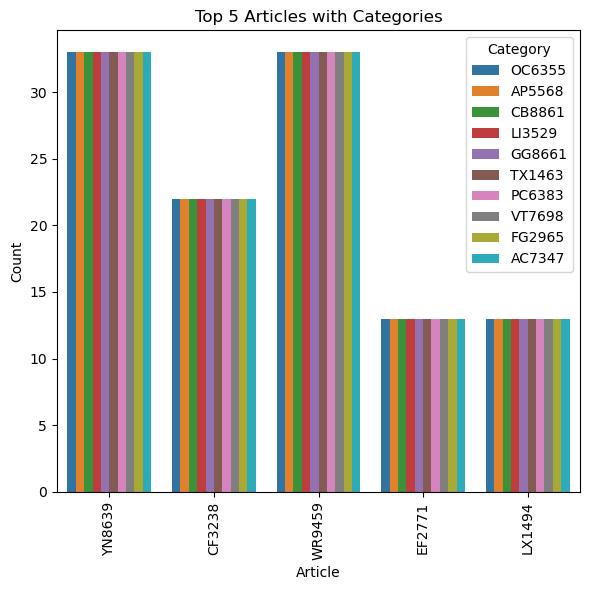

In [9]:
# Plotting Article vs category, every article have the same categories under it with same distribution of categories
top_articles = df[df['article'].isin(df['article'].head(50))]  # Filter the first 5 articles
plt.figure(figsize=(6, 6))
sns.countplot(x='article', hue='article.1', data=top_articles)
plt.xticks(rotation=90)
plt.xlabel('Article')
plt.ylabel('Count')
plt.title('Top 5 Articles with Categories')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

Not a very nice chart huh!<br>
We will do our EDA next it will further prove the previous understanding and we will focus on the important features.

## Exploratory Data Analysis (whole data)

### Checking for Nulls

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   country         100000 non-null  object 
 1   article         100000 non-null  object 
 2   sales           100000 non-null  int64  
 3   regular_price   100000 non-null  float64
 4   current_price   100000 non-null  float64
 5   ratio           100000 non-null  float64
 6   retailweek      100000 non-null  object 
 7   promo1          100000 non-null  int64  
 8   promo2          100000 non-null  int64  
 9   customer_id     100000 non-null  float64
 10  article.1       100000 non-null  object 
 11  productgroup    100000 non-null  object 
 12  category        100000 non-null  object 
 13  cost            100000 non-null  float64
 14  style           100000 non-null  object 
 15  sizes           100000 non-null  object 
 16  gender          100000 non-null  object 
 17  rgb_r_main_

No Nulls in our data.

### Checking for Outliers

In [11]:
df.describe()

,sales,regular_price,current_price,ratio,promo1,promo2,customer_id,cost,rgb_r_main_col,rgb_g_main_col,rgb_b_main_col,rgb_r_sec_col,rgb_g_sec_col,rgb_b_sec_col,label
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000
mean,56.781800,52.391200,28.290800,0.545646,0.061900,0.004900,2721.726500,6.517000,161.400000,139.600000,133.500000,207.700000,181.400000,209.900000,0.13928
std,87.934743,35.272128,22.578343,0.194363,0.240975,0.069829,1908.085499,3.914728,39.790147,63.641814,81.148727,35.313205,23.474359,45.306849,0.34624
min,1.000000,3.950000,1.950000,0.296482,0.000000,0.000000,1.000000,1.290000,79.000000,26.000000,0.000000,164.000000,155.000000,155.000000,0.00000
25%,10.000000,25.950000,11.950000,0.354839,0.000000,0.000000,1017.000000,2.290000,138.000000,104.000000,57.000000,164.000000,155.000000,155.000000,0.00000
50%,26.000000,40.950000,20.950000,0.525044,0.000000,0.000000,2091.000000,6.950000,160.000000,144.000000,143.000000,205.000000,187.000000,238.000000,0.00000
75%,64.000000,79.950000,37.950000,0.699248,0.000000,0.000000,4570.250000,9.600000,205.000000,181.000000,205.000000,255.000000,211.000000,255.000000,0.00000
max,898.000000,197.950000,195.950000,1.000000,1.000000,1.000000,5999.000000,13.290000,205.000000,238.000000,250.000000,255.000000,211.000000,255.000000,1.00000


By checking the 75% AND max for each columns, the columns that may contain outliers are:
- sales
- regular_price
- current_price

#### Investigating Columns Suspected to have outliers

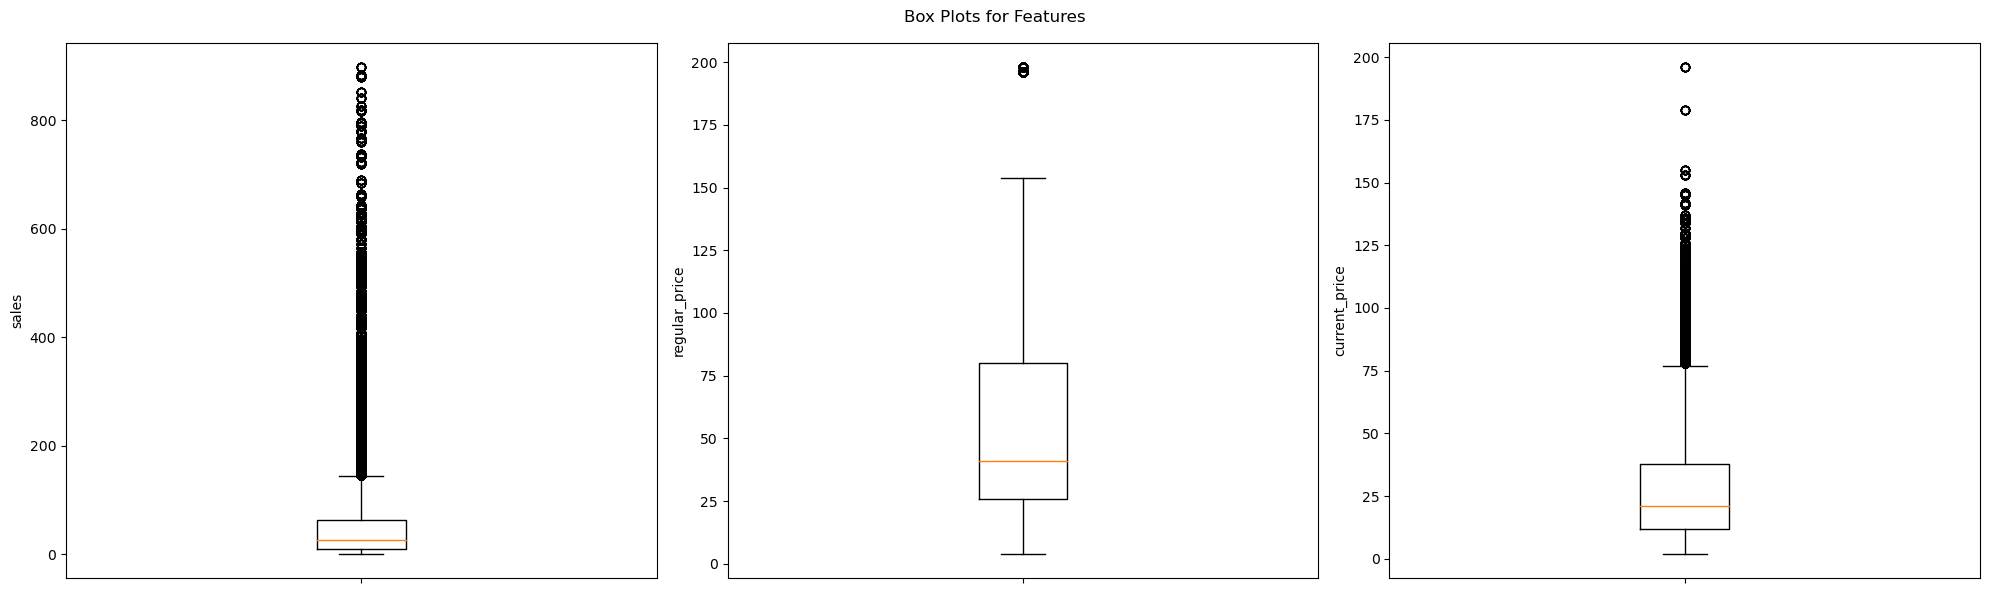

In [12]:
# Select the features to plot
features = ['sales', 'regular_price', 'current_price']

# Create a figure and subplots
fig, axes = plt.subplots(1, len(features), figsize=(20, 6))

# Iterate over the features and create box plots
for i, feature in enumerate(features):
    ax = axes[i]
    ax.boxplot(df[feature])
    ax.set_ylabel(feature)
    ax.set_xticklabels([])
    ax.set_xlabel('')

# Set a title for the entire figure
fig.suptitle('Box Plots for Features')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


Considering the nature of the feature, and that it makes sense for price and sales to be large for some products, this is not considered and error.
<br> We will use log transformation to handle the outliers and decrease its effect while keeping its information in the model.
<br>We will also investigate the relation between sales and price and what makes sales increase (which is our goal).

### Analyzing Target Variable (Class Imbalance)

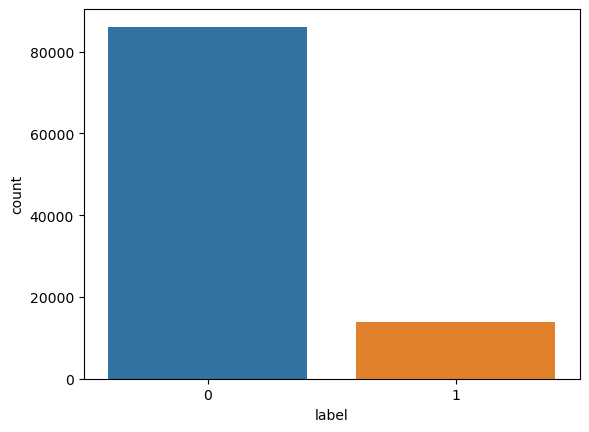

In [13]:
sns.countplot(data=df, x='label');

Apparently we have class imbalance, The minority class (0) is underrepresented by the majority class.<br>
We will use SMOTE (Synthetic Minority Over-sampling Technique) to address this issue and when evaluating our model we will use evaluation metrics that handle this imbalance as well.

### Correlation With The Target Variable

#### Numerical Features (Anova Test)

In [14]:
group_0 = df[df['label'] == 0]
group_1 = df[df['label'] == 1]

numerical_features = df.select_dtypes(include=['int64', 'float64'])

# performing ANOVA test (numerical features)
for feature in numerical_features:
    formula = f"{feature} ~ C(label)"
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = anova_table.loc['C(label)', 'PR(>F)']
    print(f"Feature: {feature}, p-value: {p_value}")


Feature: sales, p-value: 6.796643314542506e-300
Feature: regular_price, p-value: 2.0117417548189926e-06
Feature: current_price, p-value: 0.0
Feature: ratio, p-value: 0.0
Feature: promo1, p-value: 1.5002897533184924e-91
Feature: promo2, p-value: 1.8032854350911548e-10
Feature: customer_id, p-value: 0.20524100597383696
Feature: cost, p-value: 0.5005496929740039
Feature: rgb_r_main_col, p-value: 0.6745857874173824
Feature: rgb_g_main_col, p-value: 0.01707339774577323
Feature: rgb_b_main_col, p-value: 0.7010502903458105
Feature: rgb_r_sec_col, p-value: 0.34284176380605236
Feature: rgb_g_sec_col, p-value: 0.4226706090761907
Feature: rgb_b_sec_col, p-value: 0.7610128063678415
Feature: label, p-value: 0.0


Using ANOVA test to determine if there is significant difference between the mean of the two groups (0,1) for each feature, **We found that**:
<br>Columns sales, regular_price, current price, ratio, promo1 and promo2 are statistically significant and have the best impact on the target.
<br>Those are the columns we will include in our further analysis.

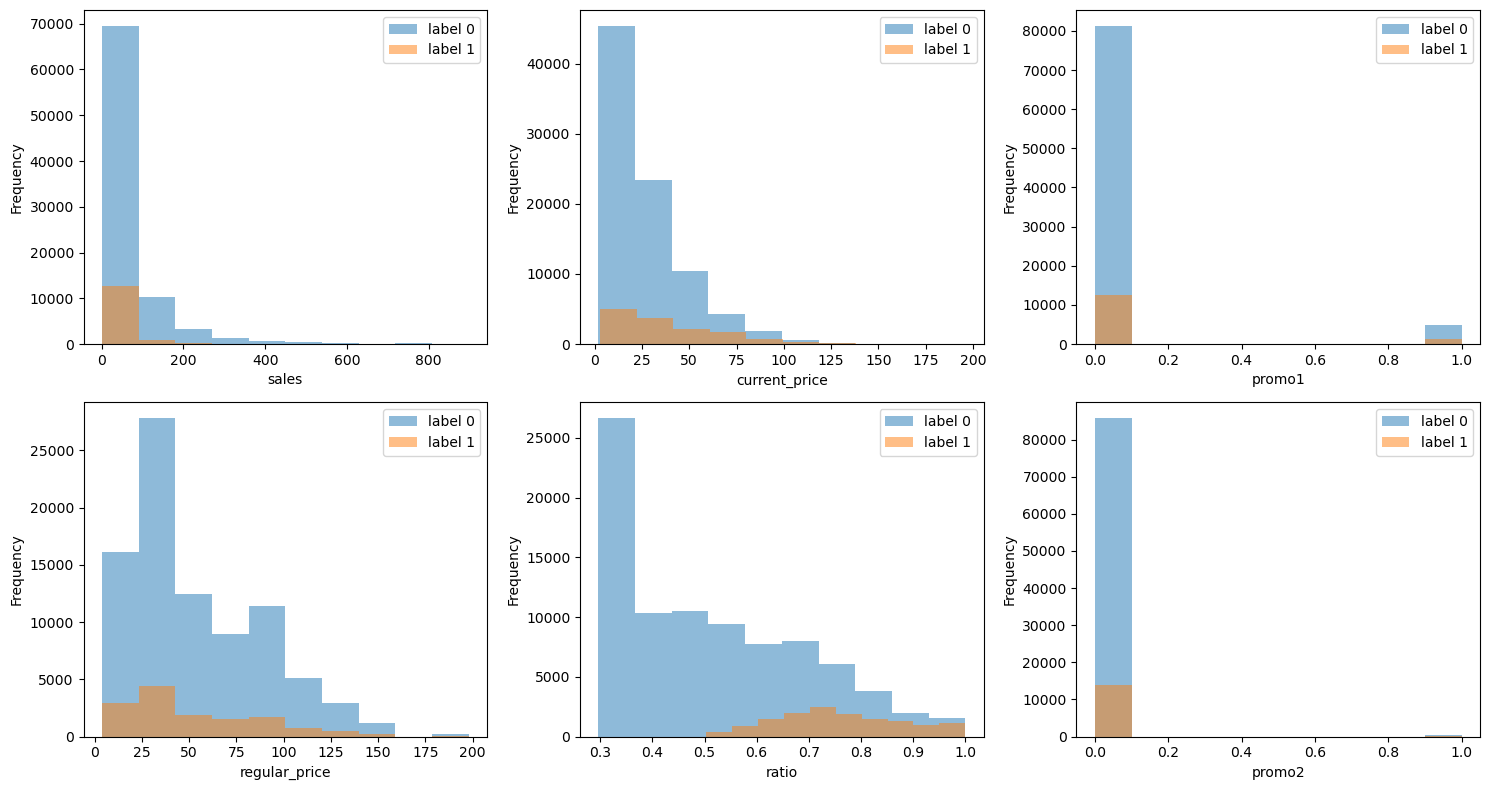

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# current_price
axes[0, 0].hist(df[df['label'] == 0]['sales'], bins=10, alpha=0.5, label='label 0')
axes[0, 0].hist(df[df['label'] == 1]['sales'], bins=10, alpha=0.5, label='label 1')
axes[0, 0].set_xlabel('sales')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# ratio
axes[0, 1].hist(df[df['label'] == 0]['current_price'], bins=10, alpha=0.5, label='label 0')
axes[0, 1].hist(df[df['label'] == 1]['current_price'], bins=10, alpha=0.5, label='label 1')
axes[0, 1].set_xlabel('current_price')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# promo1
axes[1, 0].hist(df[df['label'] == 0]['regular_price'], bins=10, alpha=0.5, label='label 0')
axes[1, 0].hist(df[df['label'] == 1]['regular_price'], bins=10, alpha=0.5, label='label 1')
axes[1, 0].set_xlabel('regular_price')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# promo2
axes[1, 1].hist(df[df['label'] == 0]['ratio'], bins=10, alpha=0.5, label='label 0')
axes[1, 1].hist(df[df['label'] == 1]['ratio'], bins=10, alpha=0.5, label='label 1')
axes[1, 1].set_xlabel('ratio')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

# promo1
axes[0, 2].hist(df[df['label'] == 0]['promo1'], bins=10, alpha=0.5, label='label 0')
axes[0, 2].hist(df[df['label'] == 1]['promo1'], bins=10, alpha=0.5, label='label 1')
axes[0, 2].set_xlabel('promo1')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()

# promo2
axes[1, 2].hist(df[df['label'] == 0]['promo2'], bins=10, alpha=0.5, label='label 0')
axes[1, 2].hist(df[df['label'] == 1]['promo2'], bins=10, alpha=0.5, label='label 1')
axes[1, 2].set_xlabel('promo2')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].legend()

plt.tight_layout()

# Show the figure
plt.show()


#### Categorical Features (Chi2 Test)

In [16]:
categorical_features = ['country', 'article', 'article.1', 'productgroup', 'category', 'style', 'sizes', 'gender']
target_variable = 'label'

# performing chi-square test for categorical features
for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df[target_variable])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print(f"Feature: {feature}, p-value: {p_value}")


Feature: country, p-value: 0.002834734138820402
Feature: article, p-value: 1.0732788687682343e-147
Feature: article.1, p-value: 0.37143740000847936
Feature: productgroup, p-value: 0.6047496723328505
Feature: category, p-value: 0.16470963236112315
Feature: style, p-value: 0.9147139404561527
Feature: sizes, p-value: 0.31948210466431737
Feature: gender, p-value: 0.7078029483154296


From our test we deducted that the only significant features that affect the target are **country and article**, these are the ones we will include in our further exploration.<br>
*Note:* This proves what we expected, the second part of the table is insignificant and won't help in our analysis.

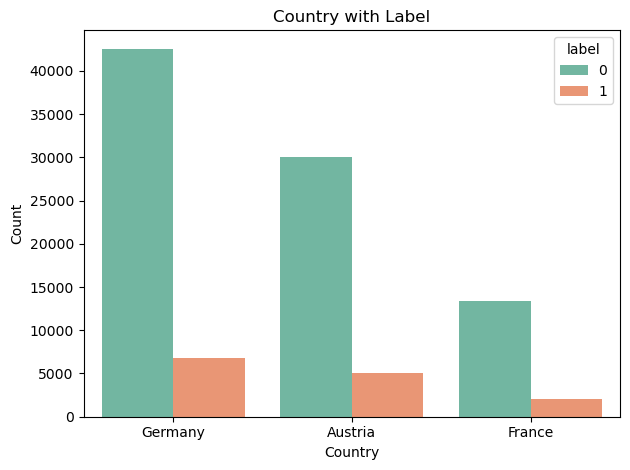

In [17]:
sns.countplot(x='country',hue='label', data=df, palette='Set2')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Country with Label')
plt.tight_layout()
plt.show()

## New Dataset with significant and relevant features

In [18]:
# now let's construct a new dataset df_s with the selected features
selected_features = ['country', 'article', 'sales', 'regular_price', 'current_price', 'ratio','retailweek', 'promo1', 'promo2', 'label']
df_s = df[selected_features].copy()

In [19]:
df_s.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,label
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0
1,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0
2,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0
3,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0
4,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0


In [20]:
#tot_0, tot_1 is the count of 0 and 1 class in the data respectively
tot_0, tot_1 = df_s.label.value_counts().tolist()
tot_0, tot_1

(86072, 13928)

We now face the problem of duplicated rows, but we can't just drop duplicates as this will cause the records to be once with +ve label and once with -ve label which will not help our analysis or model.
<br> So, we will take the **weighted majority vote** for the duplicated rows and consider it as the label for that row, then drop duplicates, if the count for +ve and -ve is the same we will have to drop that row.
<br> <br>The **Weighted** part is for handling the class imbalance we have in the data, if we don't do this step, every row will have a final label of 0 because simply the count of 0 in the dataset is much larger than the 1, so the majority vote will always give 0.

In [21]:
# Grouping by all columns except for the label column
grouped = df_s.groupby(df_s.columns.tolist()[:9])

#the division tot_ for the count is for giving a weight for the 0 and 1 according to their weight in the dataset to handle class imbalance 
df_s['m1'] = grouped['label'].transform(lambda x: (x == 0).sum()/tot_0*1e5) #adding the *1e5 is to make numbers clearer and prevent underflow as the tot is extremly larger than the count for each duplicated record.
df_s['m2'] = grouped['label'].transform(lambda x: (x == 1).sum()/tot_1*1e5)
df_s.head(10)

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,label,m1,m2
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345
1,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345
2,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345
3,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345
4,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345
5,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1,8.132726,21.539345
6,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345
7,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1,8.132726,21.539345
8,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345
9,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1,8.132726,21.539345


In [22]:
# adding final label as 0 if m1>m2, 1 if m2>m1 and -1 if they are equal (-1 rows will be dropped if any)
df_s['final_label'] = df_s.apply(lambda row: 0 if row['m1'] > row['m2'] else (1 if row['m2'] > row['m1'] else -1), axis=1)
df_s.head(10)

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,label,m1,m2,final_label
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345,1
1,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345,1
2,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345,1
3,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345,1
4,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345,1
5,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1,8.132726,21.539345,1
6,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345,1
7,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1,8.132726,21.539345,1
8,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345,1
9,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1,8.132726,21.539345,1


In [23]:
# Dropping duplicated rows based on first 9 columns
df_unique = df_s.drop_duplicates(subset=df.columns.tolist()[:9], keep='first')
df_unique.head(20)

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,label,m1,m2,final_label
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0,8.132726,21.539345,1
10,Germany,CF3238,27,37.95,28.95,0.762846,2015-01-25,0,0,0,8.132726,21.539345,1
20,Germany,WR9459,59,57.95,44.95,0.775669,2017-01-29,0,0,0,9.294544,14.359563,1
30,Austria,EF2771,72,28.95,18.95,0.654577,2017-02-26,0,0,0,8.132726,21.539345,1
40,Austria,LX1494,18,11.95,5.95,0.497908,2016-12-25,0,0,0,11.618180,0.000000,0
50,Germany,VF6733,1,63.95,57.95,0.906177,2017-02-12,0,0,0,5.809090,35.898909,1
60,Austria,YK5786,66,6.95,3.95,0.568345,2017-03-19,0,0,0,10.456362,7.179782,0
70,France,CX1431,3,23.95,23.95,1.000000,2015-02-08,0,0,0,6.970908,28.719127,1
80,Austria,TK4862,8,81.95,31.95,0.389872,2016-12-11,1,0,0,11.618180,0.000000,0
90,Austria,ZM8792,61,111.95,64.95,0.580170,2017-01-01,0,0,1,9.294544,14.359563,1


In [24]:
df_unique.final_label.value_counts()

0    6351
1    3649
Name: final_label, dtype: int64

In [25]:
# Keeping only the necessary columns
df_unique = df_unique[df.columns.tolist()[:9] + ['final_label']]

In [26]:
df_unique.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,final_label
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1
10,Germany,CF3238,27,37.95,28.95,0.762846,2015-01-25,0,0,1
20,Germany,WR9459,59,57.95,44.95,0.775669,2017-01-29,0,0,1
30,Austria,EF2771,72,28.95,18.95,0.654577,2017-02-26,0,0,1
40,Austria,LX1494,18,11.95,5.95,0.497908,2016-12-25,0,0,0


In [27]:
df_unique.shape

(10000, 10)


<div style="text-align:center">
    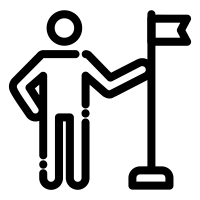
</div>


Now, we have a clean, reliable, sensible dataset that we can count on for our further analysis.<br>
**Let's confirm that with correlation test once again as we changed our label, then proceed to further analysis and insights**

In [28]:
group_0 = df_unique[df_unique['final_label'] == 0]
group_1 = df_unique[df_unique['final_label'] == 1]

numerical_features = df_unique.select_dtypes(include=['int64', 'float64'])

for feature in numerical_features:
    formula = f"{feature} ~ C(final_label)"
    model = ols(formula, data=df_unique).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = anova_table.loc['C(final_label)', 'PR(>F)']
    print(f"Feature: {feature}, p-value: {p_value}")

Feature: sales, p-value: 5.612724744641396e-104
Feature: regular_price, p-value: 0.023154185426316507
Feature: current_price, p-value: 9.742750203041432e-257
Feature: ratio, p-value: 0.0
Feature: promo1, p-value: 5.32896016693897e-32
Feature: promo2, p-value: 0.0009381014427839809
Feature: final_label, p-value: 0.0


In [29]:
categorical_features = ['country', 'article']
target_variable = 'final_label'

for feature in categorical_features:
    contingency_table = pd.crosstab(df_unique[feature], df_unique[target_variable])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print(f"Feature: {feature}, p-value: {p_value}")


Feature: country, p-value: 0.3502362932345628
Feature: article, p-value: 0.0005034056349768872


Great, all our features are significant to the target and we can use them without worrying.

## Exploratory Data Analysis (relevant/processed data)

### Feature Engineering

#### Create discount column from the ratio column

In [30]:
df_unique['discount'] = 1 - df_unique['ratio']

#### Create many features from the retail week to investigate patterns and probable seasonality or trend.
We will create "week_of_year", "month", "year", "day_of_week" and "quarter" from retailweek

In [31]:
# Converting the "retailweek" column to datetime
df_unique['retailweek'] = pd.to_datetime(df_unique['retailweek'])

# Extract week of the year
df_unique['week_of_year'] = df_unique['retailweek'].dt.isocalendar().week

# Extract month
df_unique['month'] = df_unique['retailweek'].dt.month

# Extract year
df_unique['year'] = df_unique['retailweek'].dt.year

# Extract day of the week
df_unique['day_of_week'] = df_unique['retailweek'].dt.dayofweek

# Extract quarter
df_unique['quarter'] = df_unique['retailweek'].dt.quarter

df_unique.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,final_label,discount,week_of_year,month,year,day_of_week,quarter
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1,0.336134,12,3,2016,6,1
10,Germany,CF3238,27,37.95,28.95,0.762846,2015-01-25,0,0,1,0.237154,4,1,2015,6,1
20,Germany,WR9459,59,57.95,44.95,0.775669,2017-01-29,0,0,1,0.224331,4,1,2017,6,1
30,Austria,EF2771,72,28.95,18.95,0.654577,2017-02-26,0,0,1,0.345423,8,2,2017,6,1
40,Austria,LX1494,18,11.95,5.95,0.497908,2016-12-25,0,0,0,0.502092,51,12,2016,6,4


#### We will also create a column for segmented articles
We will segment the articles to Premium, Regular and Affordable according to their current Price.

In [32]:
# Calculate sales statistics for each article
article_sales_stats = df_unique.groupby('article')['current_price'].agg(['mean', 'median', 'sum'])

most_purchased_threshold = article_sales_stats['mean'].quantile(0.75)
low_purchased_threshold = article_sales_stats['mean'].quantile(0.25)

# Segmenting the articles based on quantity
def segment_articles(quantity):
    if quantity >= most_purchased_threshold:
        return 'Premium'
    elif quantity >= low_purchased_threshold:
        return 'Regular'
    else:
        return 'Affordable'

df_unique['price_category'] = df_unique['current_price'].apply(segment_articles)

segment_counts = df_unique['price_category'].value_counts()
print(segment_counts)


Regular       4593
Affordable    3228
Premium       2179
Name: price_category, dtype: int64


In [33]:
df_unique.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,final_label,discount,week_of_year,month,year,day_of_week,quarter,price_category
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,1,0.336134,12,3,2016,6,1,Affordable
10,Germany,CF3238,27,37.95,28.95,0.762846,2015-01-25,0,0,1,0.237154,4,1,2015,6,1,Regular
20,Germany,WR9459,59,57.95,44.95,0.775669,2017-01-29,0,0,1,0.224331,4,1,2017,6,1,Premium
30,Austria,EF2771,72,28.95,18.95,0.654577,2017-02-26,0,0,1,0.345423,8,2,2017,6,1,Regular
40,Austria,LX1494,18,11.95,5.95,0.497908,2016-12-25,0,0,0,0.502092,51,12,2016,6,4,Affordable


In [34]:
# Desired order of columns
new_column_order = ['country', 'article', 'sales', 'regular_price', 'current_price',
       'ratio', 'retailweek', 'promo1', 'promo2', 'discount',
       'week_of_year', 'month', 'year', 'day_of_week', 'quarter',
       'price_category', 'final_label']

# Reindex the DataFrame with the new column order
df_unique = df_unique.reindex(columns=new_column_order)

In [35]:
df_unique.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,discount,week_of_year,month,year,day_of_week,quarter,price_category,final_label
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0.336134,12,3,2016,6,1,Affordable,1
10,Germany,CF3238,27,37.95,28.95,0.762846,2015-01-25,0,0,0.237154,4,1,2015,6,1,Regular,1
20,Germany,WR9459,59,57.95,44.95,0.775669,2017-01-29,0,0,0.224331,4,1,2017,6,1,Premium,1
30,Austria,EF2771,72,28.95,18.95,0.654577,2017-02-26,0,0,0.345423,8,2,2017,6,1,Regular,1
40,Austria,LX1494,18,11.95,5.95,0.497908,2016-12-25,0,0,0.502092,51,12,2016,6,4,Affordable,0


### Analysis

In [36]:
df_unique.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 99990
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   country         10000 non-null  object        
 1   article         10000 non-null  object        
 2   sales           10000 non-null  int64         
 3   regular_price   10000 non-null  float64       
 4   current_price   10000 non-null  float64       
 5   ratio           10000 non-null  float64       
 6   retailweek      10000 non-null  datetime64[ns]
 7   promo1          10000 non-null  int64         
 8   promo2          10000 non-null  int64         
 9   discount        10000 non-null  float64       
 10  week_of_year    10000 non-null  UInt32        
 11  month           10000 non-null  int64         
 12  year            10000 non-null  int64         
 13  day_of_week     10000 non-null  int64         
 14  quarter         10000 non-null  int64         
 15  pr

In [37]:
df_unique.describe()

,sales,regular_price,current_price,ratio,promo1,promo2,discount,week_of_year,month,year,day_of_week,quarter,final_label
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.00000,10000.000000
mean,56.781800,52.391200,28.290800,0.545646,0.061900,0.004900,0.454354,24.343500,5.905600,2015.702500,6.0,2.32250,0.364900
std,87.938701,35.273715,22.579359,0.194372,0.240986,0.069832,0.194372,15.615585,3.531421,0.718781,0.0,1.13632,0.481426
min,1.000000,3.950000,1.950000,0.296482,0.000000,0.000000,0.000000,1.000000,1.000000,2014.000000,6.0,1.00000,0.000000
25%,10.000000,25.950000,11.950000,0.354839,0.000000,0.000000,0.300752,10.750000,3.000000,2015.000000,6.0,1.00000,0.000000
50%,26.000000,40.950000,20.950000,0.525044,0.000000,0.000000,0.474956,22.000000,5.000000,2016.000000,6.0,2.00000,0.000000
75%,64.000000,79.950000,37.950000,0.699248,0.000000,0.000000,0.645161,38.000000,9.000000,2016.000000,6.0,3.00000,1.000000
max,898.000000,197.950000,195.950000,1.000000,1.000000,1.000000,0.703518,53.000000,12.000000,2017.000000,6.0,4.00000,1.000000


Remember we still have our outliers in the sales, current and regular peice columns that we will transform After analysis and before modeling.

### Relation with target
- Promos
- Countries
- Discount and ratio
- Current and regular Price
- Price Category
- Sales

Exploring the relation between **promos on article and article being bought**.

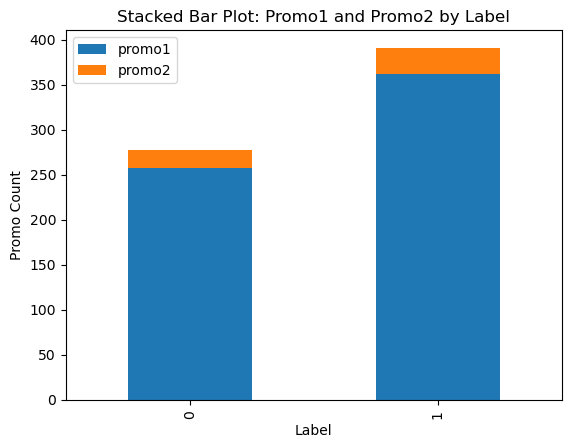

In [38]:
promo_counts = df_unique.groupby('final_label')[['promo1', 'promo2']].sum()
promo_counts.plot(kind='bar', stacked=True)
plt.xlabel('Label')
plt.ylabel('Promo Count')
plt.title('Stacked Bar Plot: Promo1 and Promo2 by Label')
plt.show()

We can see that people are more inclined to buy when there is a promo, to see which is more effective, we find the difference between people buying using each promo and people not buying and normalize this difference to the total count of that promo.

In [39]:
diff = (promo_counts.loc[1] - promo_counts.loc[0])
diff

promo1    105
promo2      9
dtype: int64

In [40]:
total = (promo_counts.loc[1] + promo_counts.loc[0])
total

promo1    619
promo2     49
dtype: int64

In [41]:
effectivness = diff / total
effectivness

promo1    0.169628
promo2    0.183673
dtype: float64

By analysis both the promos are effective by 16 - 18 %, in store promos are a little more effective so we can leverage it or start finding more creative ways to work on it.

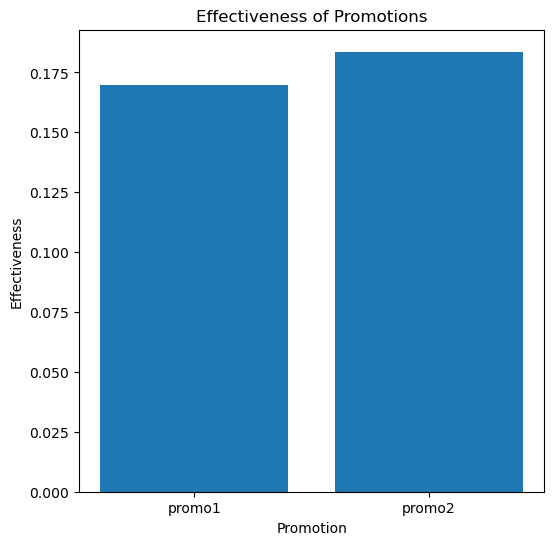

In [45]:
# bar chart for effectivness
plt.figure(figsize=(6, 6))
plt.bar(effectivness.index, effectivness)
plt.xlabel('Promotion')
plt.ylabel('Effectiveness')
plt.title('Effectiveness of Promotions')

# Show the chart
plt.show()



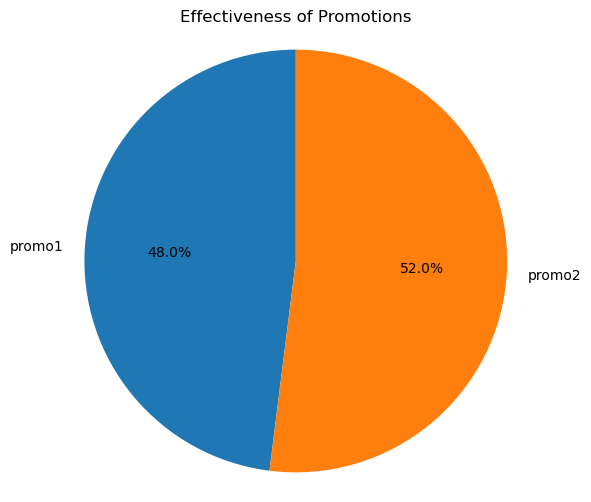

In [43]:
# Creating a pie chart for effectivness
plt.figure(figsize=(6, 6))
plt.pie(effectivness, labels=effectivness.index, autopct='%1.1f%%', startangle=90)
plt.title('Effectiveness of Promotions')
plt.axis('equal')

# Show the chart
plt.show()

Now, let's explore the relation between **countries and label**

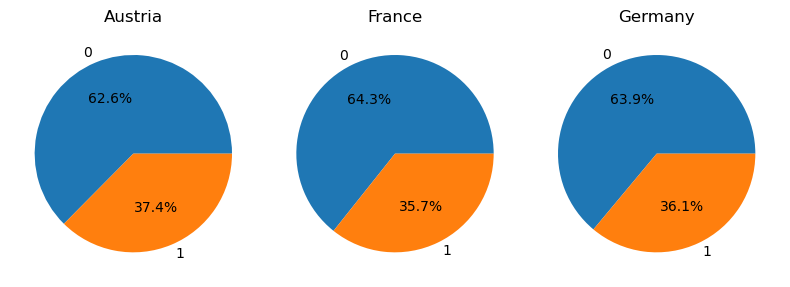

In [46]:
# Grouping the data by country and label and counting the occurrences
country_label_counts = df_unique.groupby(['country', 'final_label']).size().unstack()

# Creating a pie chart for each country
fig, axes = plt.subplots(ncols=len(country_label_counts), figsize=(8, 6))

for i, (country, data) in enumerate(country_label_counts.iterrows()):
    # Plot a pie chart for the country
    axes[i].pie(data, labels=data.index, autopct='%1.1f%%')
    axes[i].set_title(country)

plt.tight_layout()
plt.show()

All countries have the same percentage of buying. but what is the percentage of each country from the total buying?

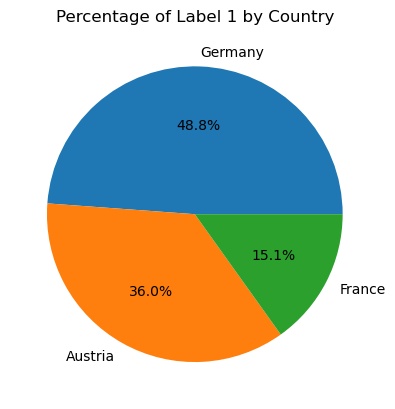

In [47]:
# Filtering the data for label 1
df_label_1 = df_unique[df_unique['final_label'] == 1]

# Grouping the data by country and calculate the percentage of label 1
country_label_1_percentage = df_label_1['country'].value_counts(normalize=True) * 100

# Plot the pie chart
plt.pie(country_label_1_percentage, labels=country_label_1_percentage.index, autopct='%1.1f%%')
plt.title("Percentage of Label 1 by Country")
plt.show()


This is because the amount of rows with the country germany is larger though.

In [48]:
df_unique.country.value_counts()

Germany    4940
Austria    3514
France     1546
Name: country, dtype: int64

Now, what is the relation between **discount column and label**

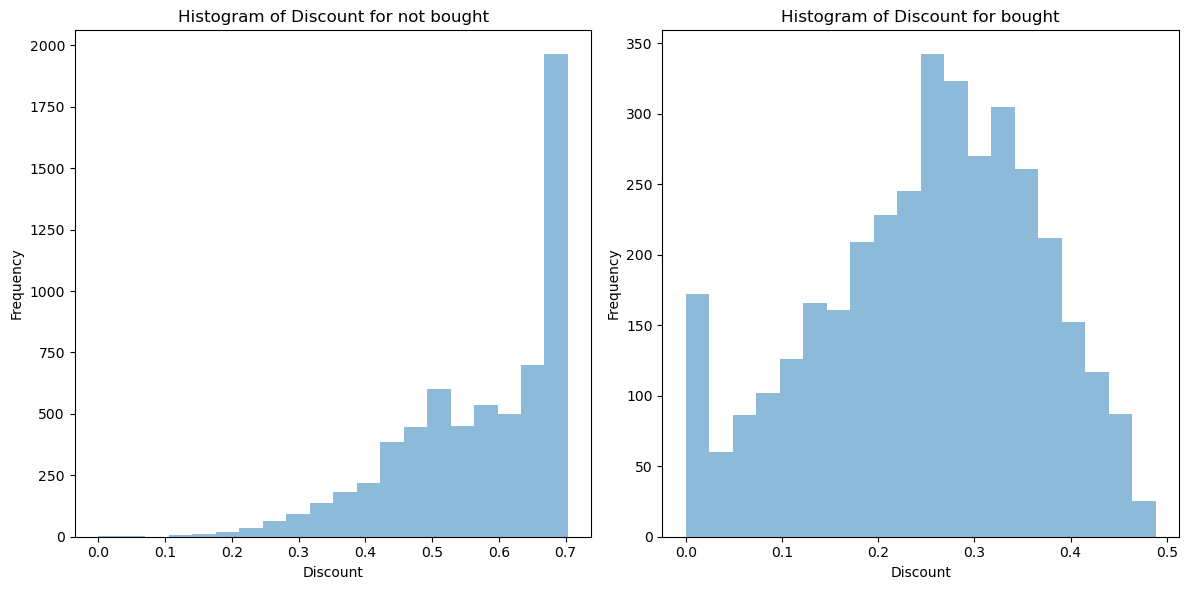

In [49]:
# Separating data for each label category
label_0_data = df_unique[df_unique['final_label'] == 0]['discount']
label_1_data = df_unique[df_unique['final_label'] == 1]['discount']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# histogram for label 0
ax1.hist(label_0_data, bins=20, alpha=0.5)
ax1.set_title('Histogram of Discount for not bought')
ax1.set_xlabel('Discount')
ax1.set_ylabel('Frequency')

# histograms for label 1
ax2.hist(label_1_data, bins=20, alpha=0.5)
ax2.set_title('Histogram of Discount for bought')
ax2.set_xlabel('Discount')
ax2.set_ylabel('Frequency')

plt.tight_layout()

plt.show()


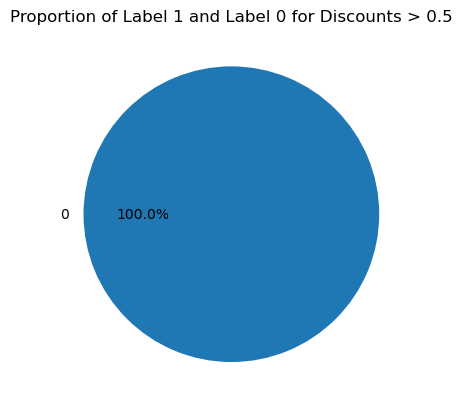

In [50]:
# Filtering data for discounts greater than 0.5
filtered_data = df_unique[df_unique['discount'] > 0.49]

# Counting the occurrences of label 1 and label 0
label_counts = filtered_data['final_label'].value_counts()

plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Proportion of Label 1 and Label 0 for Discounts > 0.5')

plt.show()

For all discounts more than 0.5, products was not bought!<br>
Apparently, while discount increase products tend to be not bought! this is weird but it enlighten us that we can focus our marketing efforts not on finding discounts and offers to customers but more on branding and online and offline events.

What about the relation of the **ratio with the label**? will it prove what we saw from the discount?<br>
The answer is yes, it will give us the same exact graphs mirrored on the y axis as discount = (1-ratio)

The relation of convergence **(buying) with the current_price** indictaes as the price increase, the probability of items being sold is larger.

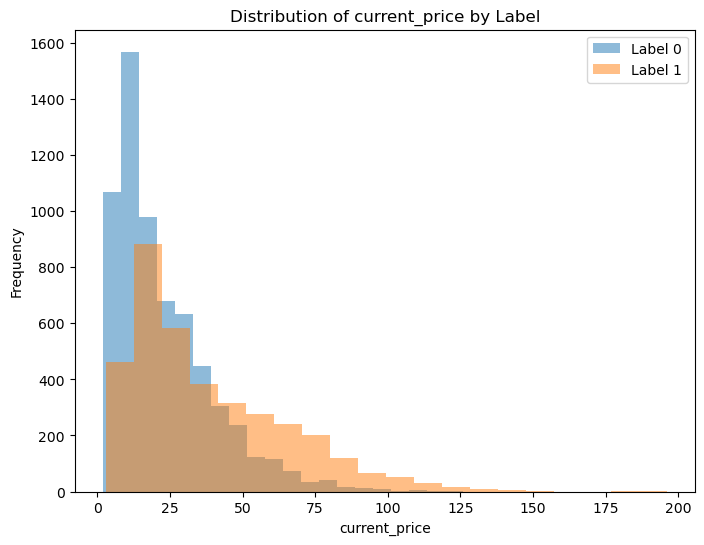

In [51]:
label_0_data = df_unique[df_unique['final_label'] == 0]['current_price']
label_1_data = df_unique[df_unique['final_label'] == 1]['current_price']

plt.figure(figsize=(8, 6))
plt.hist(label_0_data, bins=20, alpha=0.5, label='Label 0')
plt.hist(label_1_data, bins=20, alpha=0.5, label='Label 1')
plt.xlabel('current_price')
plt.ylabel('Frequency')
plt.title('Distribution of current_price by Label')
plt.legend()
plt.show()

We will investigate this further by looking at the relation of **price_category and label**

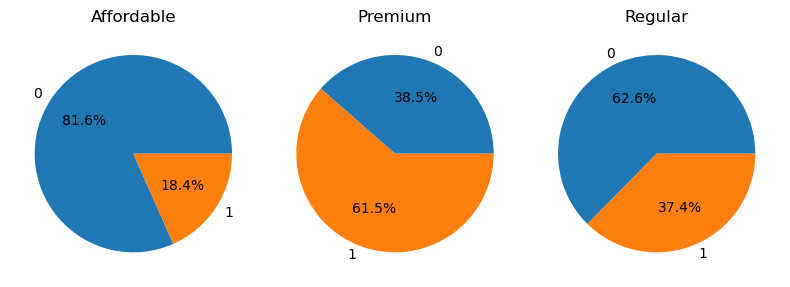

In [52]:
# Grouping the data by country and label and counting the occurrences
category_label_counts = df_unique.groupby(['price_category', 'final_label']).size().unstack()

fig, axes = plt.subplots(ncols=len(category_label_counts), figsize=(8, 6))

for i, (category, data) in enumerate(category_label_counts.iterrows()):
    # Plot a pie chart for the country
    axes[i].pie(data, labels=data.index, autopct='%1.1f%%')
    axes[i].set_title(category)

plt.tight_layout()
plt.show()

The Premium products are considered the least risky and the one with much potential, following it is the regular then the affordable which is considered the worst performing category.
<br> But, according to the following chart

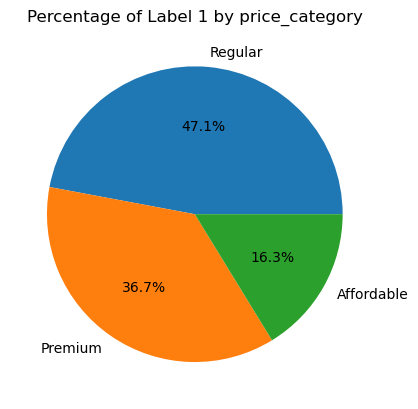

In [53]:
# Filtering for label 1
df_label_1 = df_unique[df_unique['final_label'] == 1]

# calculating the percentage of label 1 for each country
country_label_1_percentage = df_label_1['price_category'].value_counts(normalize=True) * 100

plt.pie(country_label_1_percentage, labels=country_label_1_percentage.index, autopct='%1.1f%%')
plt.title("Percentage of Label 1 by price_category")
plt.show()

People are more inclined to buy normally priced items then high priced then the low priced items.

The **regular price** doesn't appear to have a relevant pattern with the label, which makes sense as label depends more on the current_price as stated before.

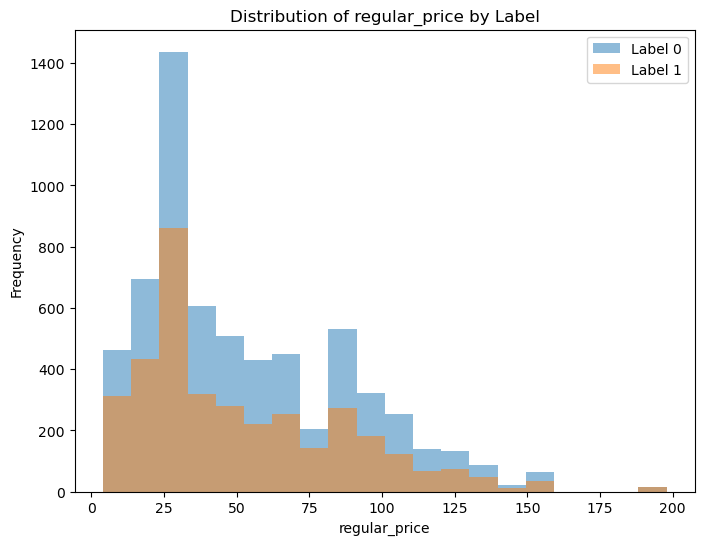

In [54]:
label_0_data = df_unique[df_unique['final_label'] == 0]['regular_price']
label_1_data = df_unique[df_unique['final_label'] == 1]['regular_price']

plt.figure(figsize=(8, 6))
plt.hist(label_0_data, bins=20, alpha=0.5, label='Label 0')
plt.hist(label_1_data, bins=20, alpha=0.5, label='Label 1')
plt.xlabel('regular_price')
plt.ylabel('Frequency')
plt.title('Distribution of regular_price by Label')
plt.legend()
plt.show()

Finally, Let's check the relation of **sales with the label**, we expect the sales to have large effect on whether the product is more likely to be bought, we expect that for the as the sales increase for one product it will probably to be bought further.

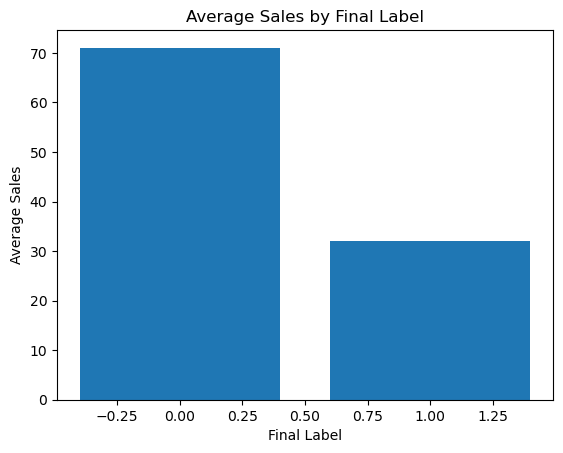

In [55]:
avg_sales_by_label = df_unique.groupby('final_label')['sales'].mean()

plt.bar(avg_sales_by_label.index, avg_sales_by_label)

# Set the plot title and labels
plt.title('Average Sales by Final Label')
plt.xlabel('Final Label')
plt.ylabel('Average Sales')

plt.show()

It is not the case though, apparently the articles that are bought have sales up to 35 max, while the ones with recorded high sales will not probably be bought further.

Now, we will investigate the relations of features with each other, and also check for multicollinearity across features.

### Relations between features
- sales vs current and regular price
- promo1,2 and sales

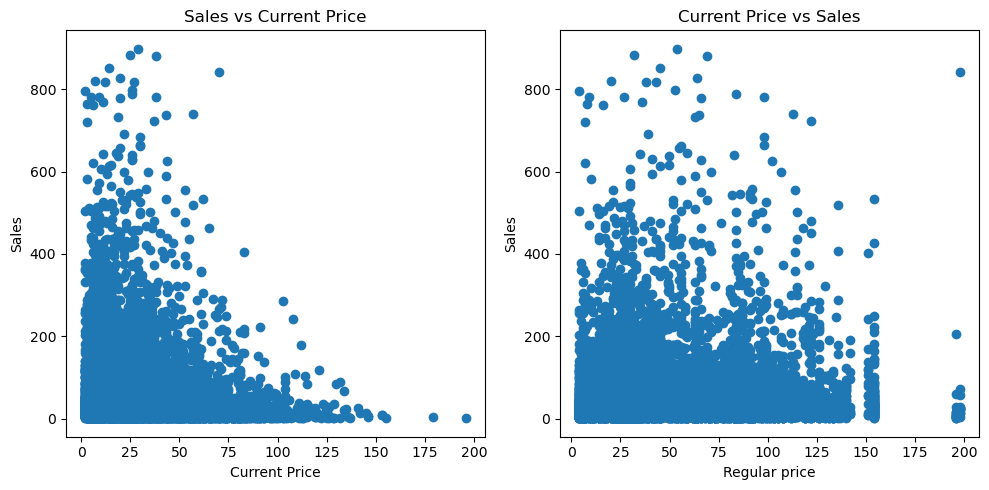

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Scatter plot for Sales vs Current Price
ax1.scatter(df_unique['current_price'], df_unique['sales'])
ax1.set_xlabel('Current Price')
ax1.set_ylabel('Sales')
ax1.set_title('Sales vs Current Price')

# Scatter plot for Sales vs Regular Price 
ax2.scatter(df_unique['regular_price'], df_unique['sales'])
ax2.set_xlabel('Regular price')
ax2.set_ylabel('Sales')
ax2.set_title('Current Price vs Sales')

plt.tight_layout()
plt.show()

Apparently, Most of the top sales are located with the smallest current prices.
<br> One interesting observation though is that there is that there is a record with very high regular price and very high sales, this could be in a trending time or season or affected by any other feature though.

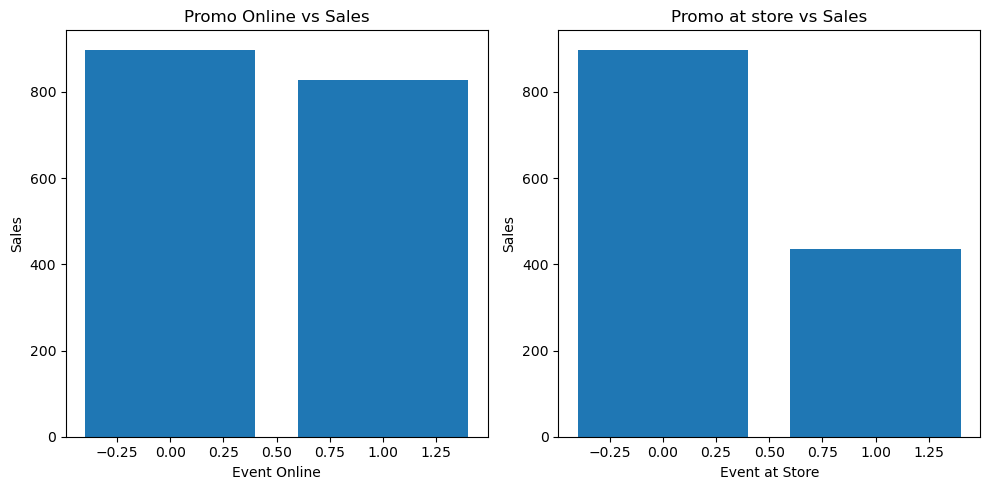

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# bare plot for promo 1 vs sales
ax1.bar(df_unique['promo1'], df_unique['sales'])
ax1.set_xlabel('Event Online')
ax1.set_ylabel('Sales')
ax1.set_title('Promo Online vs Sales')

# Scatter plot for promo 2 vs sales 
ax2.bar(df_unique['promo2'], df_unique['sales'])
ax2.set_xlabel('Event at Store')
ax2.set_ylabel('Sales')
ax2.set_title('Promo at store vs Sales')

plt.tight_layout()

plt.show()

### Relations across time

#### Label across time

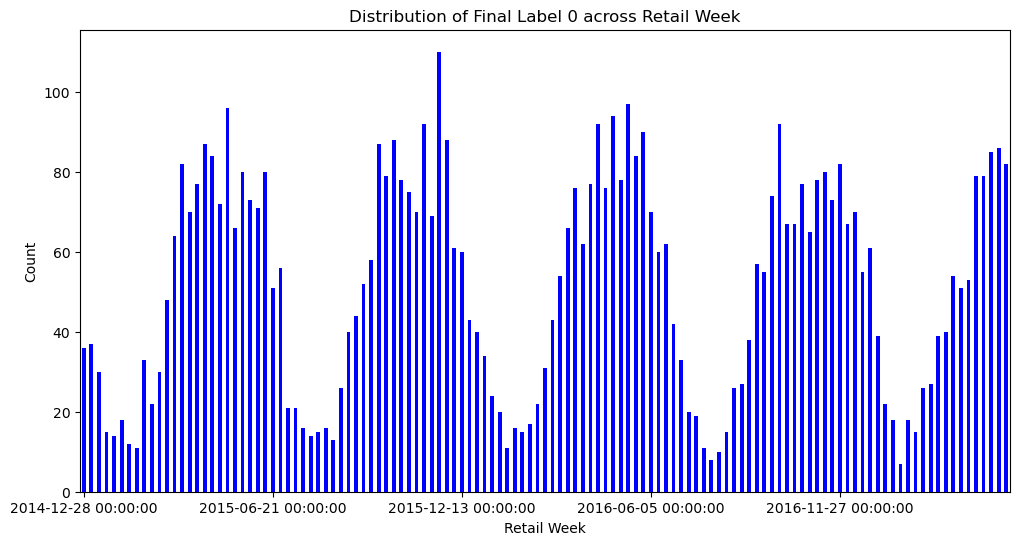

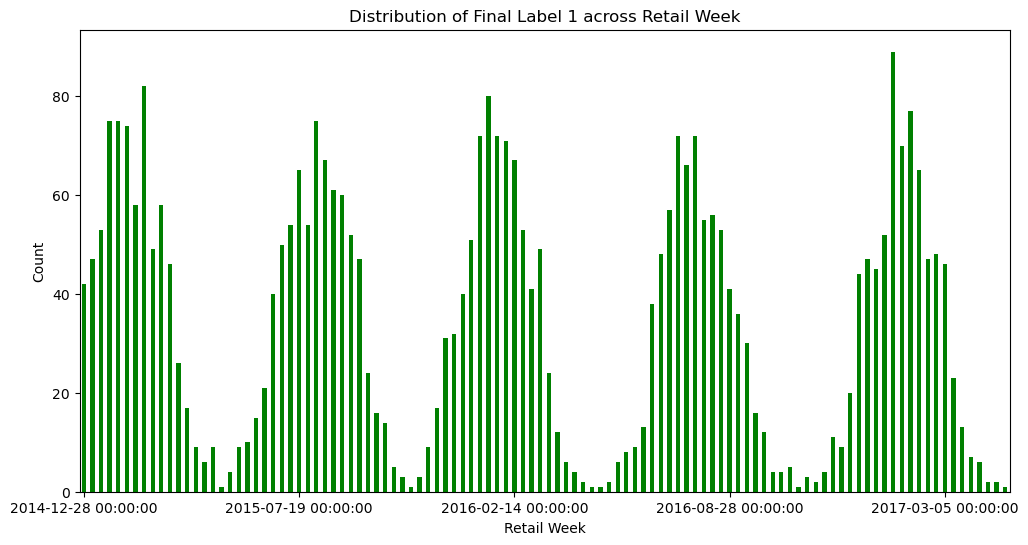

In [78]:
label0_data = df_unique[df_unique['final_label'] == 0]
label1_data = df_unique[df_unique['final_label'] == 1]

# Plotting the bar plot for label 0
plt.figure(figsize=(12, 6))
label0_counts = label0_data.groupby('retailweek').size()
label0_counts.plot(kind='bar', color='blue')
plt.xlabel('Retail Week')
plt.ylabel('Count')
plt.title('Distribution of Final Label 0 across Retail Week')

# Reducing the numbers on the x-axis
x_ticks = range(0, len(label0_counts), 25)
x_labels = label0_counts.index[x_ticks]
plt.xticks(x_ticks, x_labels, rotation=0)

plt.show()

# Plotting the bar plot for label 1
plt.figure(figsize=(12, 6))
label1_counts = label1_data.groupby('retailweek').size()
label1_counts.plot(kind='bar', color='green')
plt.xlabel('Retail Week')
plt.ylabel('Count')
plt.title('Distribution of Final Label 1 across Retail Week')

x_ticks = range(0, len(label1_counts), 25)
x_labels = label1_counts.index[x_ticks]
plt.xticks(x_ticks, x_labels, rotation=0)

plt.show()


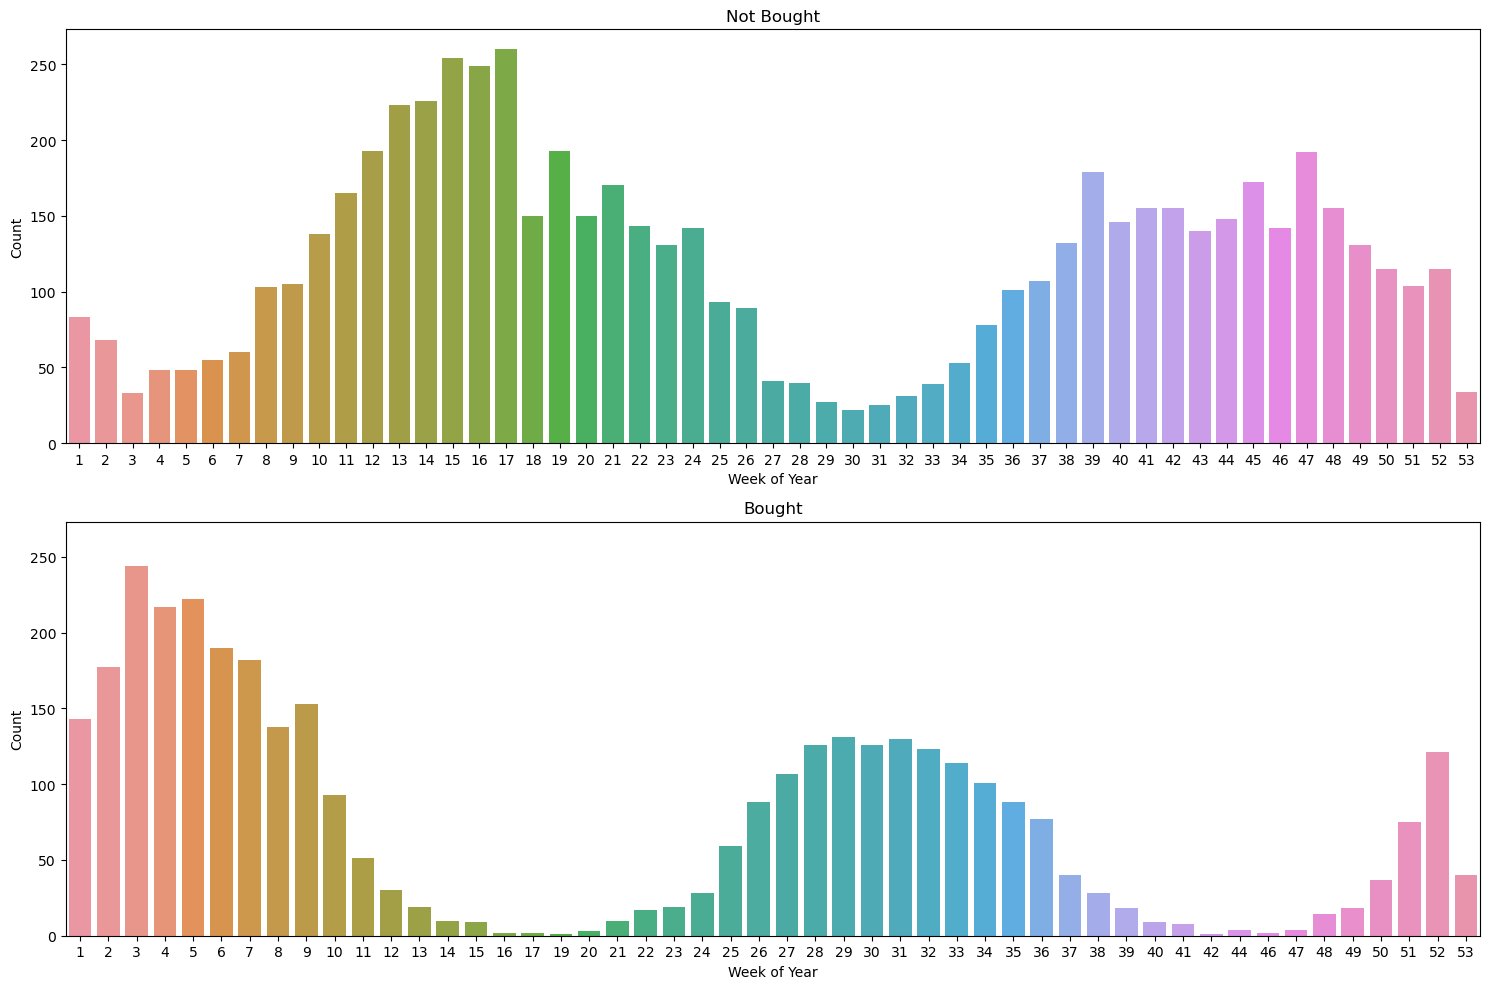

In [175]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharey=True)

# count plot for final_label 0
sns.countplot(x='week_of_year', data=df_unique[df_unique['final_label'] == 0], ax=axes[0])
axes[0].set_title('Not Bought')
axes[0].set_xlabel('Week of Year')
axes[0].set_ylabel('Count')

# count plot for final_label 1
sns.countplot(x='week_of_year', data=df_unique[df_unique['final_label'] == 1], ax=axes[1])
axes[1].set_title('Bought')
axes[1].set_xlabel('Week of Year')
axes[1].set_ylabel('Count')

plt.tight_layout()

plt.show()


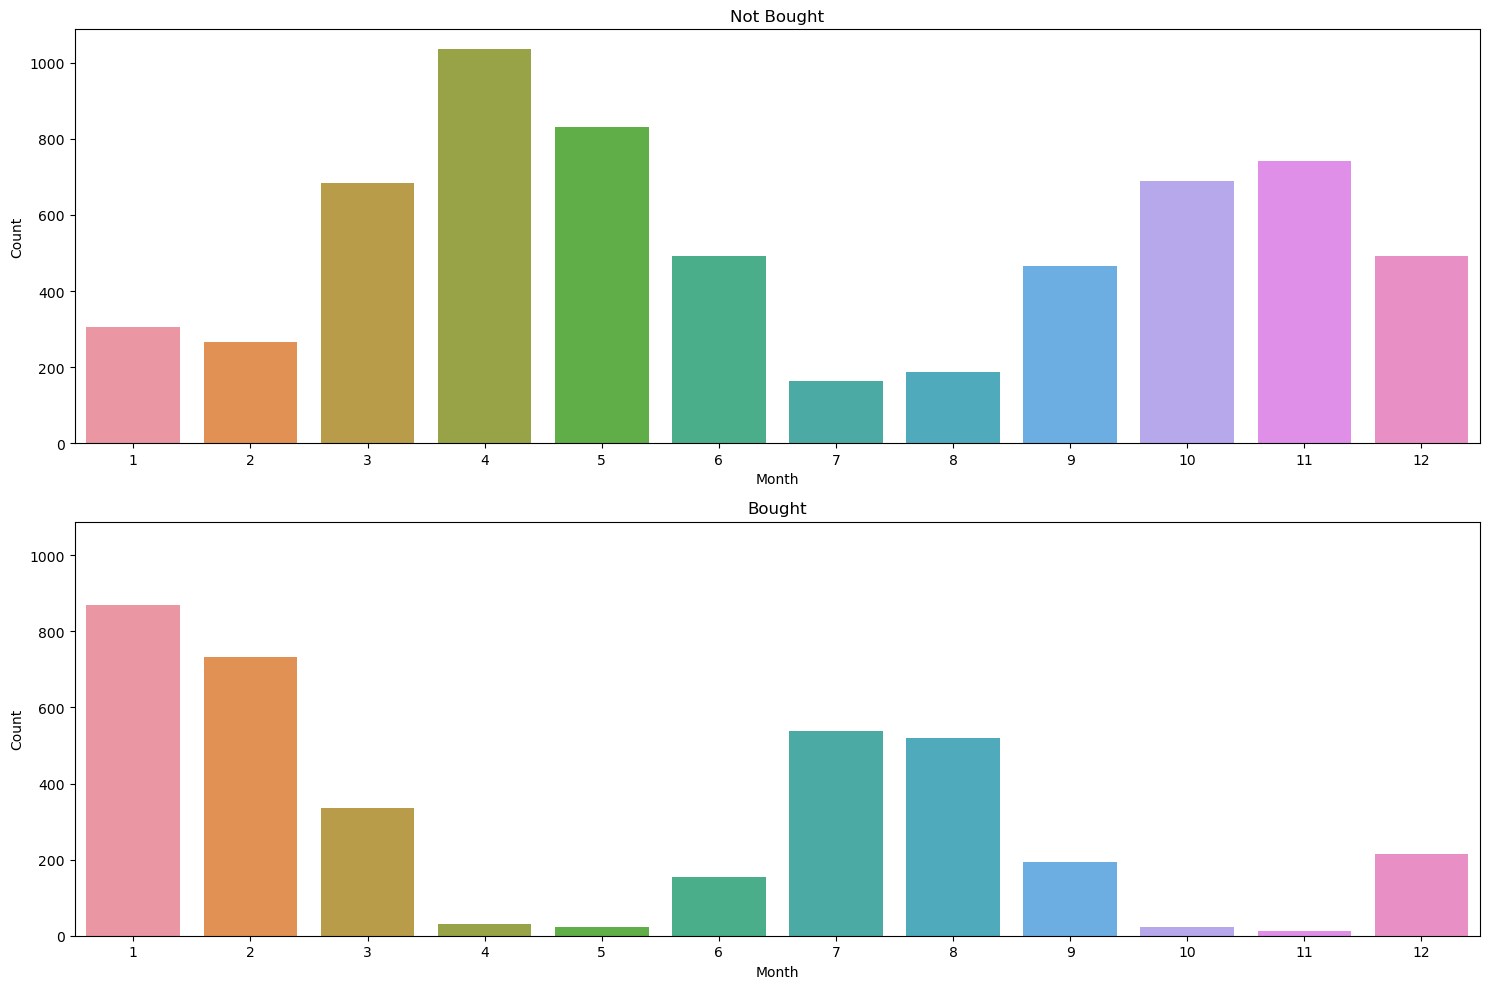

In [176]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharey=True)

# count plot for final_label 0
sns.countplot(x='month', data=df_unique[df_unique['final_label'] == 0], ax=axes[0])
axes[0].set_title('Not Bought')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Count')

# count plot for final_label 1
sns.countplot(x='month', data=df_unique[df_unique['final_label'] == 1], ax=axes[1])
axes[1].set_title('Bought')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')

plt.tight_layout()

plt.show()


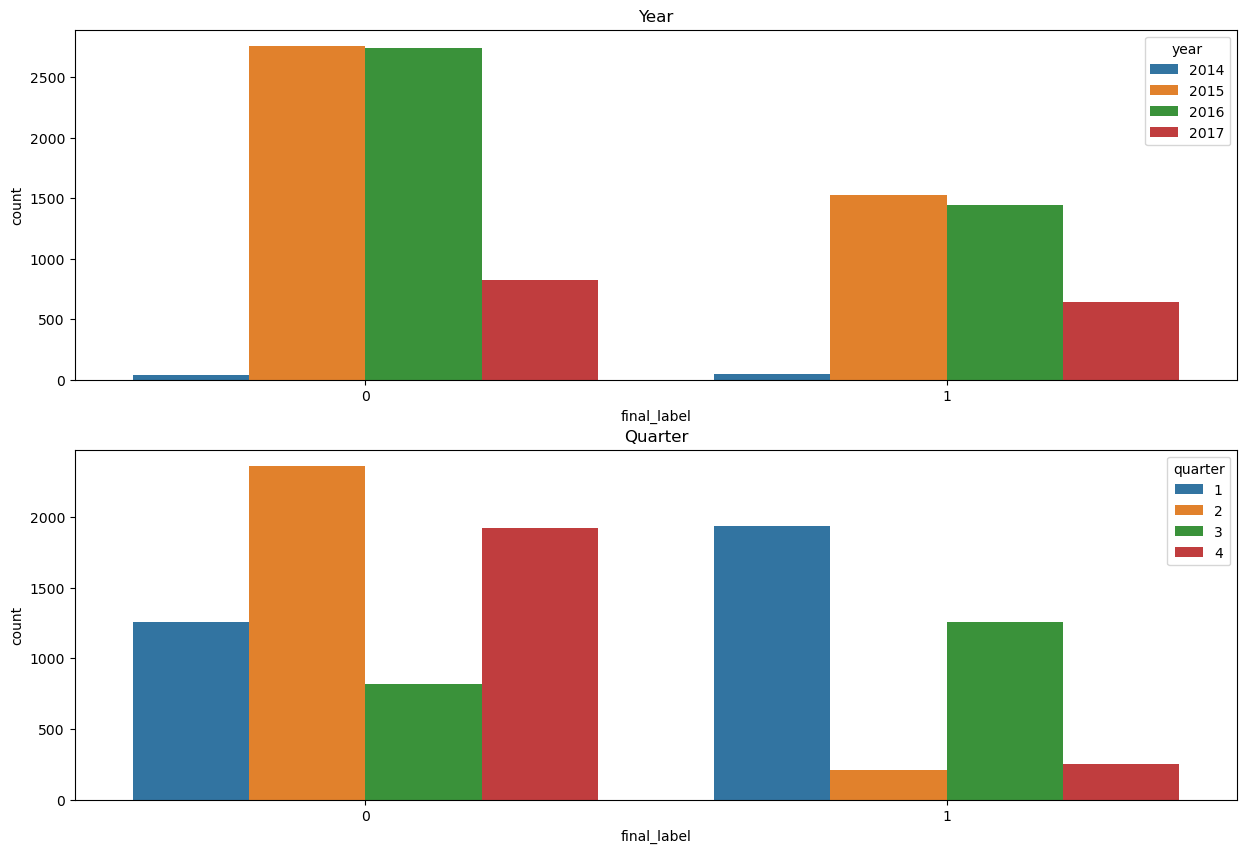

In [178]:
# Create subplots for each categorical variable
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot count plots for year and quarter
sns.countplot(x='final_label', hue='year', data=df_unique, ax=axes[0])
sns.countplot(x='final_label', hue='quarter', data=df_unique, ax=axes[1])

axes[0].set_title('Year')
axes[1].set_title('Quarter')

plt.show()


#### Sales across time
- Average

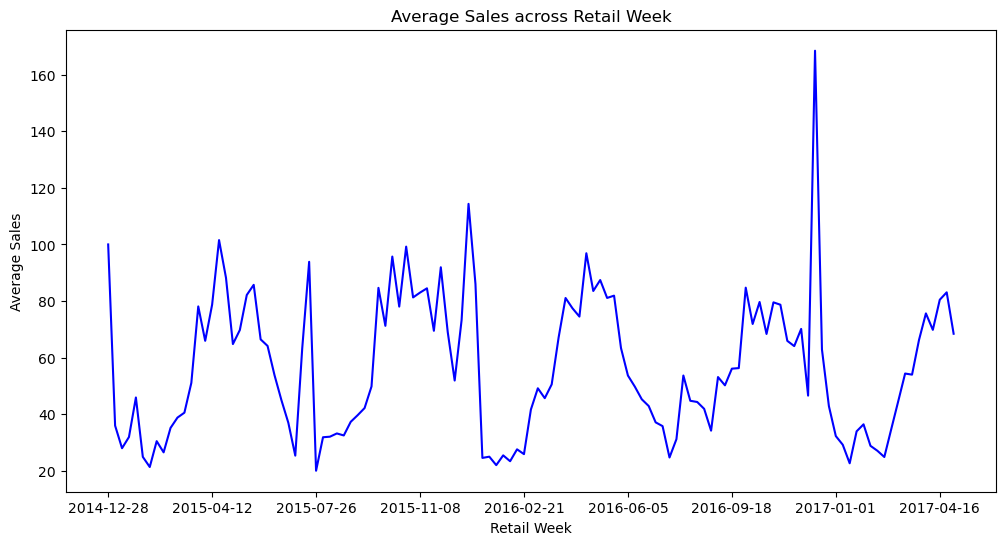

In [81]:
# Groupping the data by retail week and calculate the average sales
sales_avg = df_unique.groupby('retailweek')['sales'].mean()

# line chart for sales
plt.figure(figsize=(12, 6))
plt.plot(sales_avg.index, sales_avg, color='blue')
plt.xlabel('Retail Week')
plt.ylabel('Average Sales')
plt.title('Average Sales across Retail Week')

x_ticks = range(0, len(sales_avg), 15)
x_labels = sales_avg.index[x_ticks]
plt.xticks(x_labels, rotation=0)

plt.show()


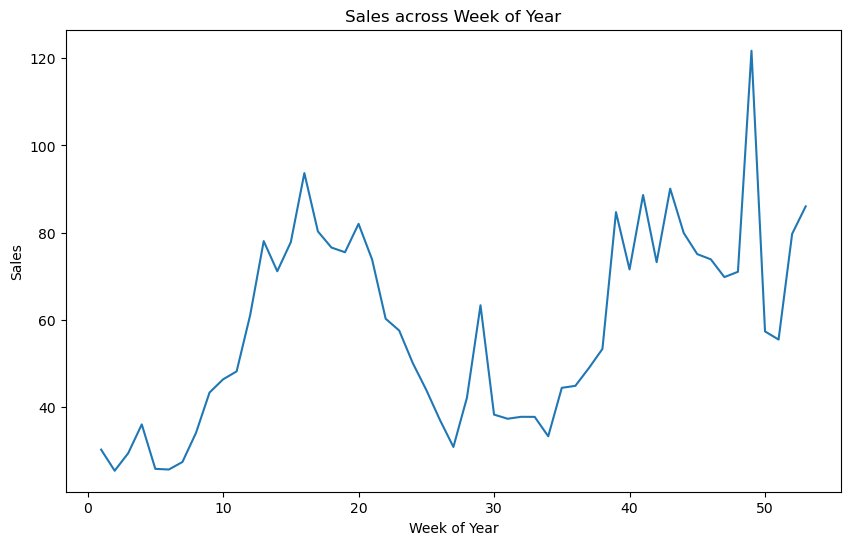

In [82]:
# Line plot for week of year
plt.figure(figsize=(10, 6))
df_unique.groupby('week_of_year')['sales'].mean().plot()
plt.xlabel('Week of Year')
plt.ylabel('Sales')
plt.title('Sales across Week of Year')
plt.show()

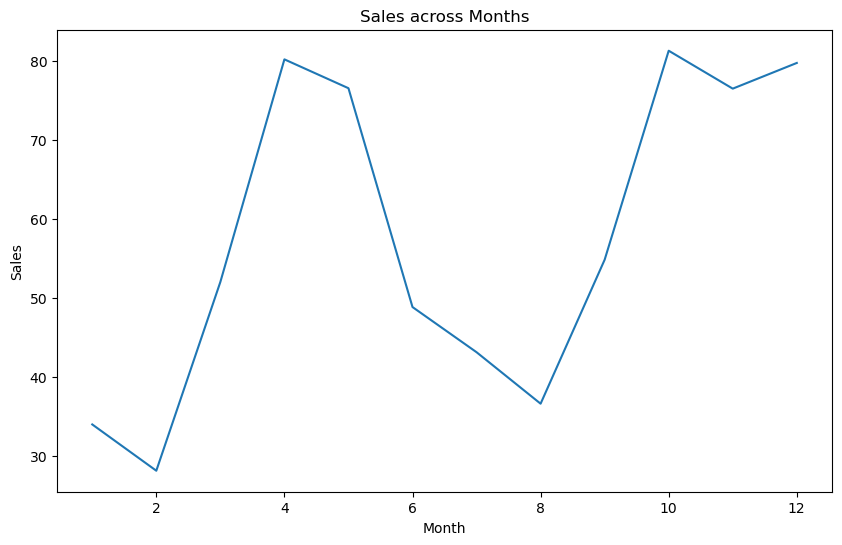

In [83]:
# Line plot for month
plt.figure(figsize=(10, 6))
df_unique.groupby('month')['sales'].mean().plot()
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales across Months')
plt.show()

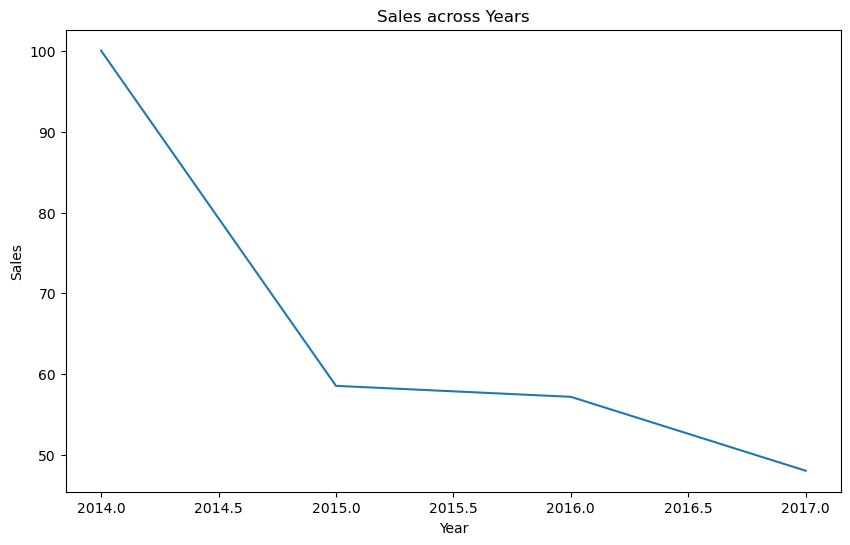

In [84]:
# Line plot for year
plt.figure(figsize=(10, 6))
df_unique.groupby('year')['sales'].mean().plot()
plt.xlabel('Year')
plt.ylabel('Sales')
plt.title('Sales across Years')
plt.show()

- Sum

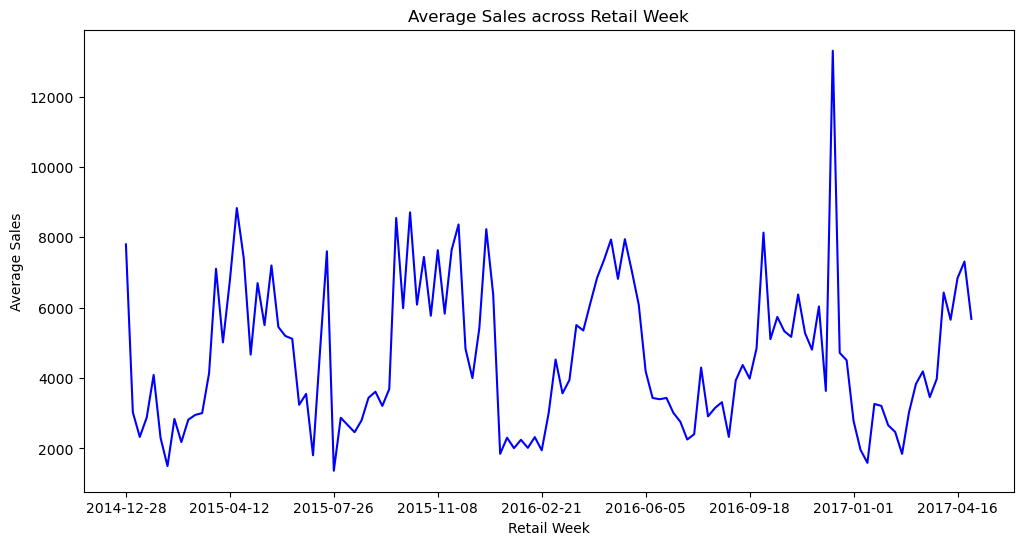

In [87]:
# Group the data by retail week and calculate the average sales
sales_avg = df_unique.groupby('retailweek')['sales'].sum()

# line chart for sales
plt.figure(figsize=(12, 6))
plt.plot(sales_avg.index, sales_avg, color='blue')
plt.xlabel('Retail Week')
plt.ylabel('Average Sales')
plt.title('Average Sales across Retail Week')

x_ticks = range(0, len(sales_avg), 15)
x_labels = sales_avg.index[x_ticks]
plt.xticks(x_labels, rotation=0)

plt.show()


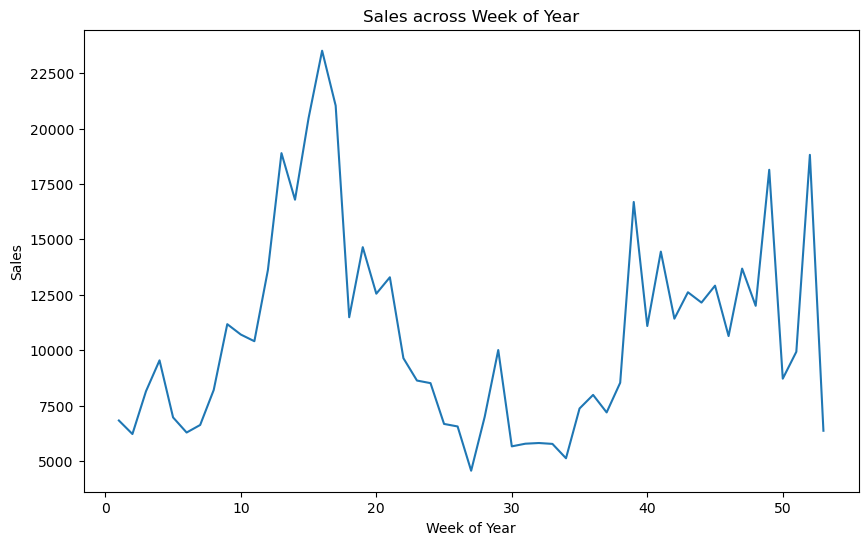

In [88]:
# Line plot for week of year
plt.figure(figsize=(10, 6))
df_unique.groupby('week_of_year')['sales'].sum().plot()
plt.xlabel('Week of Year')
plt.ylabel('Sales')
plt.title('Sales across Week of Year')
plt.show()


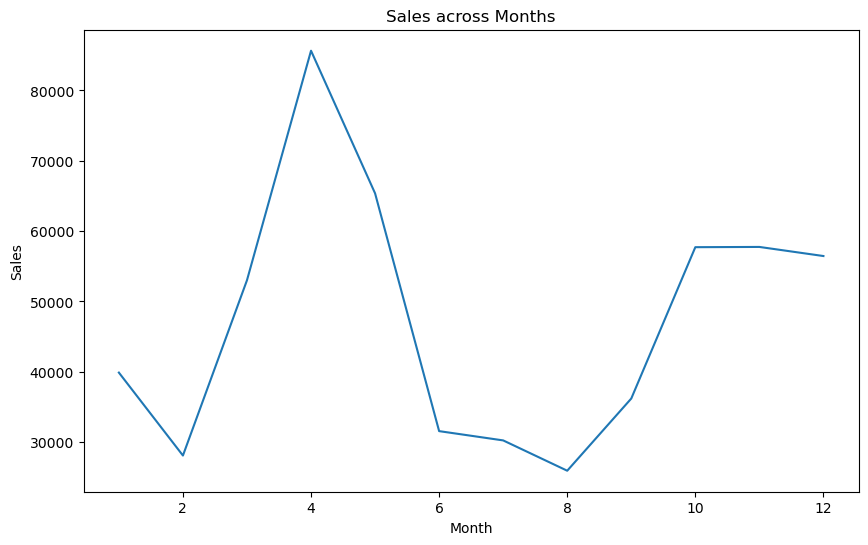

In [89]:
# Line plot for month
plt.figure(figsize=(10, 6))
df_unique.groupby('month')['sales'].sum().plot()
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales across Months')
plt.show()

## Questions and Insights

1) Which Products have the highest sales?

article
IR3275    4584
AA7884    4264
IB8671    4051
BR3179    4046
OP1184    4008
Name: sales, dtype: int64


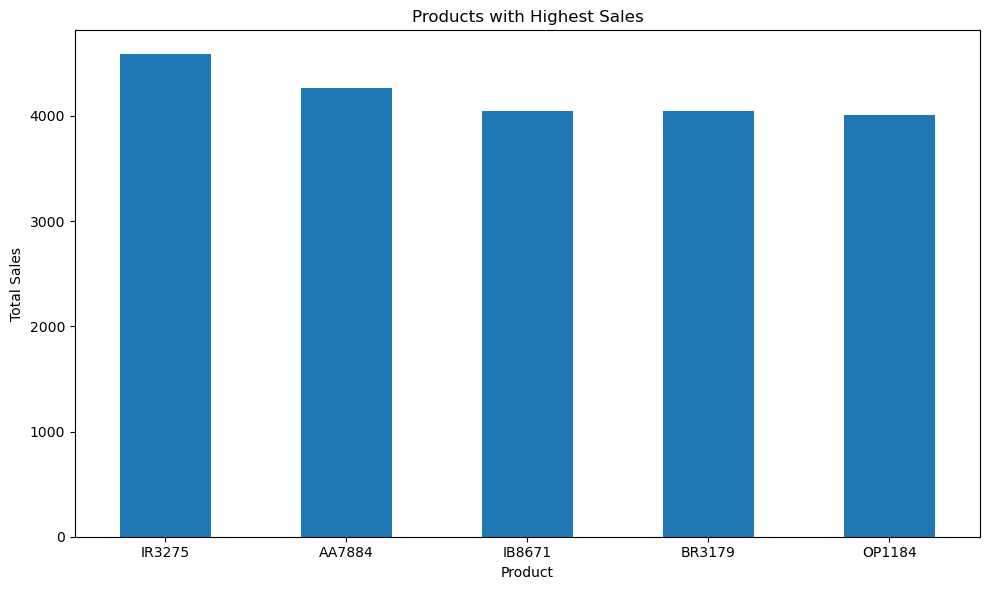

In [94]:
# Groupping the data by product and calculating the total sales
product_sales = df_unique.groupby('article')['sales'].sum()

# Sorting products by sales descendingly
sorted_products = product_sales.sort_values(ascending=False)

print(sorted_products.head())

# bar chart for products with highest sales
plt.figure(figsize=(10, 6))
sorted_products.head().plot(kind='bar')
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.title('Products with Highest Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


2) Which products are the most likely to be bought?

article
XG6449    25
BR3179    25
ST3419    24
MA7179    22
BS7795    21
Name: final_label, dtype: int64


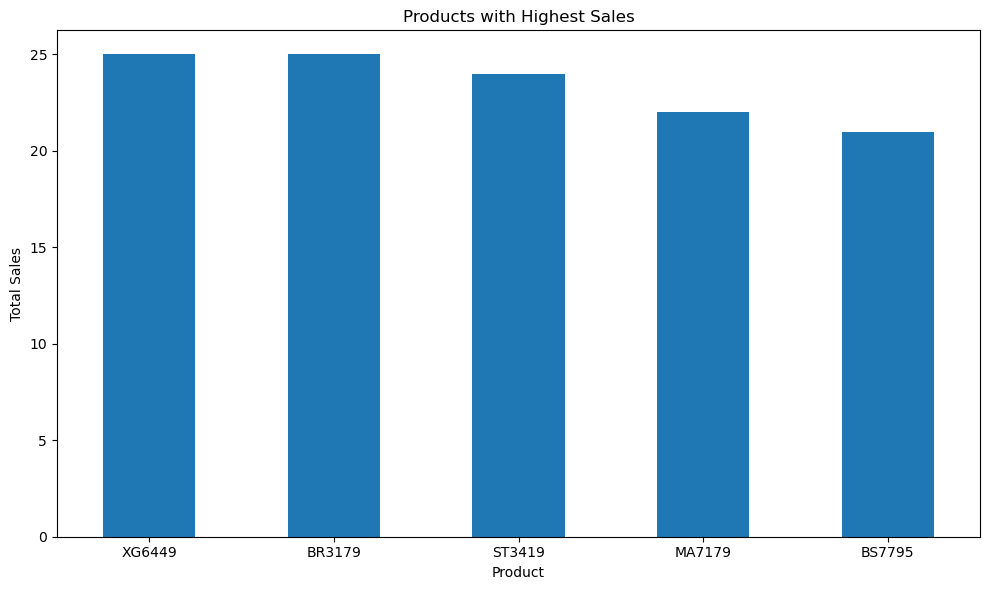

In [97]:
# Grouping the data by product and calculating the total sales
product_sales = df_unique.groupby('article')['final_label'].sum()

# Sort products by sales descendingly
sorted_products = product_sales.sort_values(ascending=False)

print(sorted_products.head())

# Plot bar chart for products with highest sales
plt.figure(figsize=(10, 6))
sorted_products.head().plot(kind='bar')
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.title('Products with Highest Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

3) Which Country has the highest sales?

In [98]:
df_unique.head()

,country,article,sales,regular_price,current_price,ratio,retailweek,promo1,promo2,discount,week_of_year,month,year,day_of_week,quarter,price_category,final_label
0,Germany,YN8639,28,5.95,3.95,0.663866,2016-03-27,0,0,0.336134,12,3,2016,6,1,Affordable,1
10,Germany,CF3238,27,37.95,28.95,0.762846,2015-01-25,0,0,0.237154,4,1,2015,6,1,Regular,1
20,Germany,WR9459,59,57.95,44.95,0.775669,2017-01-29,0,0,0.224331,4,1,2017,6,1,Premium,1
30,Austria,EF2771,72,28.95,18.95,0.654577,2017-02-26,0,0,0.345423,8,2,2017,6,1,Regular,1
40,Austria,LX1494,18,11.95,5.95,0.497908,2016-12-25,0,0,0.502092,51,12,2016,6,4,Affordable,0


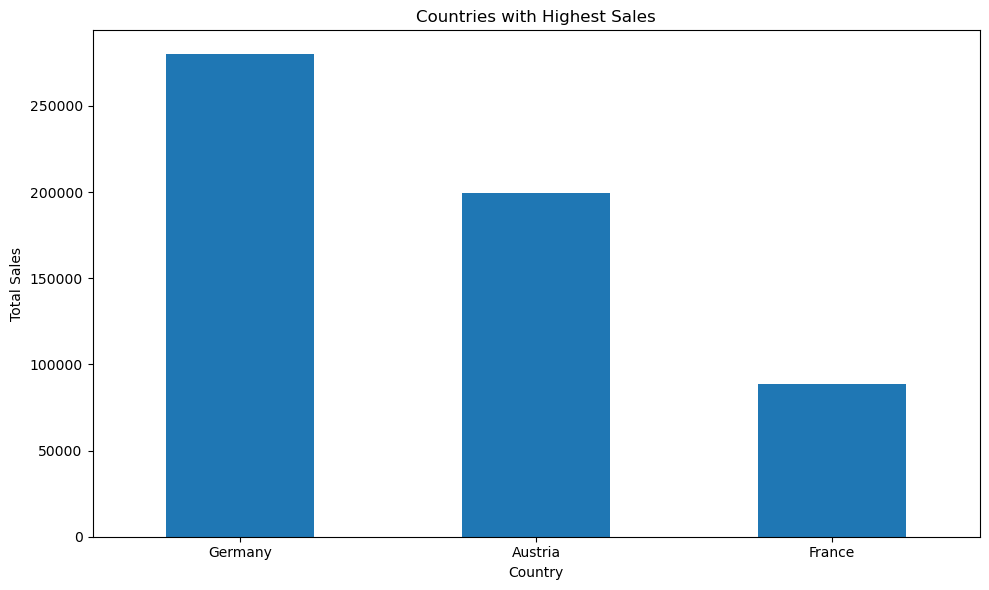

In [100]:
# Grouping the data by country and calculate total sales
sales_by_country = df_unique.groupby('country')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sales_by_country.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.title('Countries with Highest Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

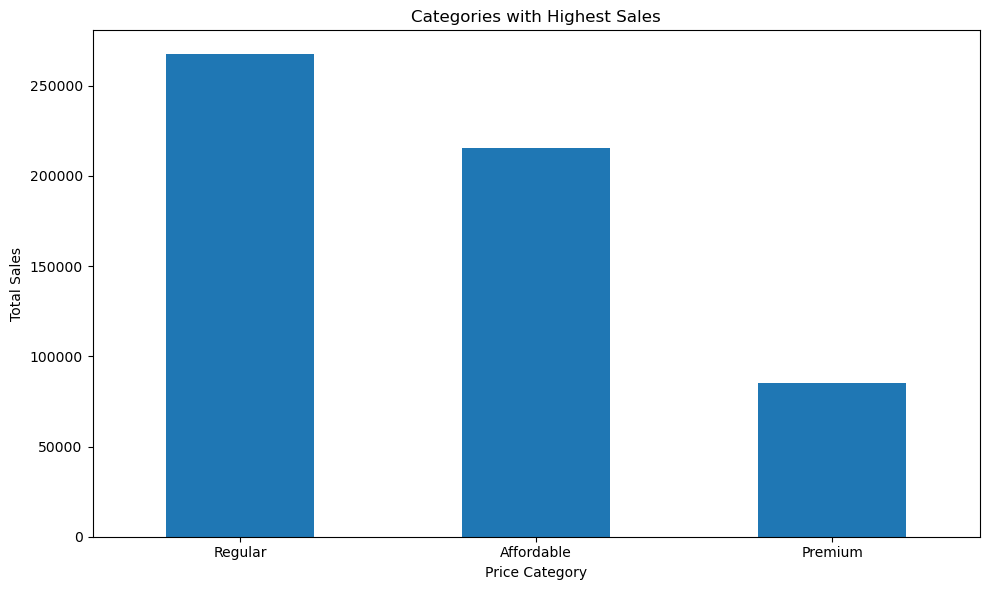

In [102]:
# Group the data by prive_category and calculate total sales
sales_by_country = df_unique.groupby('price_category')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sales_by_country.plot(kind='bar')
plt.xlabel('Price Category')
plt.ylabel('Total Sales')
plt.title('Categories with Highest Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

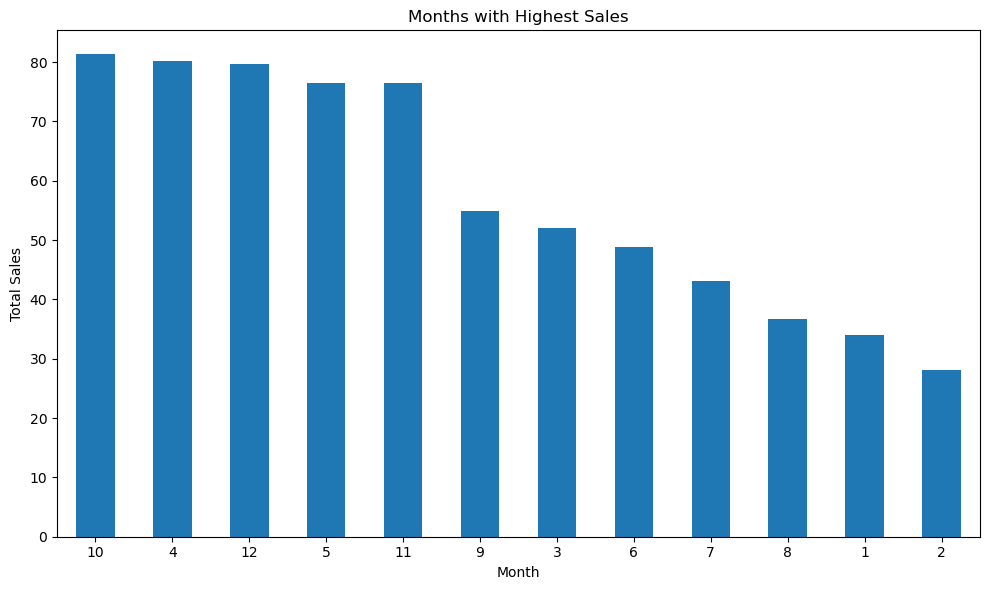

In [112]:
# Group the data by month and calculate total sales
sales_by_country = df_unique.groupby('month')['sales'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sales_by_country.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Months with Highest Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

We need to replace the numbers by the name of the month.

## Recommendations For Business and Marketing 

### Summary

The presentation and documentation will have a full summary for all recommendation driven from all the previous analysis as well as the upcoming model along with all the charts needed. It will include how our insights and analytics capabilities can help improve the marketing performance of SportsWear Group.

### How to leverage the Cloud

The presentation will also include the part of "how can SportsWear Group leverage the Cloud" as the company is interested in this part percisely.

## Data Preprocessing

### Checking Multicollinearity

Of course, our derived and added features will cause multicollinearity like the added discount column which is completely collinear with the ration column.

We will use **Variance Inflation Factor (VIF)** to see the correlation between features and if one feature directly affect the other

In [37]:
features = df_unique.select_dtypes(include=['int64', 'float64']).columns[:-1].tolist()
features.remove('ratio')
features

['sales',
 'regular_price',
 'current_price',
 'promo1',
 'promo2',
 'discount',
 'month',
 'year',
 'day_of_week',
 'quarter']

In [38]:
# Creating a DataFrame with the selected features
df_vif = df_unique[features]

# constant column for the intercept
df_vif = sm.add_constant(df_vif)

# VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = df_vif.columns
vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

# Filtering out features with infinite VIF values
vif = vif.replace([np.inf, -np.inf], np.nan).dropna()

print(vif)


         Feature           VIF
0          sales  1.108645e+00
1  regular_price  9.160467e+00
2  current_price  1.102276e+01
3         promo1  1.145960e+00
4         promo2  1.012045e+00
5       discount  3.495210e+00
6          month  1.947557e+01
7           year  1.141979e+00
8    day_of_week  8.983607e+06
9        quarter  1.909261e+01


The higher the VIF the higher the multicollinearity of that feature, so we go to the feature selection step where we decrease the multicollinearity to get the best features with high and interpretable effect on our model.

### Feature Selection

Any feature with VIF higher than 5 has strong multicollinearity, we will try now the sensible selection of features and see the multi collinearity and the correlation with the label, if finw we will try them with our model.

In [39]:
features = ['sales', 'current_price', 'promo1', 'promo2', 'discount', 'month', 'year']

In [40]:
# Creating a DataFrame with the selected features
df_vif = df_unique[features]

# constant column for the intercept
df_vif = sm.add_constant(df_vif)

# VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = df_vif.columns
vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

# Filtering out features with infinite VIF values
vif = vif.replace([np.inf, -np.inf], np.nan).dropna()

print(vif)

         Feature           VIF
0          const  8.919828e+06
1          sales  1.108114e+00
2  current_price  1.205946e+00
3         promo1  1.144016e+00
4         promo2  1.007651e+00
5       discount  1.473693e+00
6          month  1.347242e+00
7           year  1.133739e+00


### Transformation and Scaling

In [41]:
features = ['sales', 'current_price', 'promo1', 'promo2', 'discount', 'month', 'year', 'price_category']

In [50]:
df_m = df_unique[features].copy() 
df_m.loc[:, 'label'] = df_unique['final_label']
df_m.head()

,sales,current_price,promo1,promo2,discount,month,year,price_category,label
0,28,3.95,0,0,0.336134,3,2016,Affordable,1
10,27,28.95,0,0,0.237154,1,2015,Regular,1
20,59,44.95,0,0,0.224331,1,2017,Premium,1
30,72,18.95,0,0,0.345423,2,2017,Regular,1
40,18,5.95,0,0,0.502092,12,2016,Affordable,0


In [51]:
small_constant = 1e-6  # Small constant value to add to avoid log 0

df_m['sales'] = np.log(df_m['sales'] + small_constant)
df_m['current_price'] = np.log(df_m['current_price'] + small_constant)


In [52]:
df_m.describe()

,sales,current_price,promo1,promo2,discount,month,year,label
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.202272e+00,3.022857,0.061900,0.004900,0.454354,5.905600,2015.702500,0.364900
std,1.375593e+00,0.850078,0.240986,0.069832,0.194372,3.531421,0.718781,0.481426
min,9.999995e-07,0.667830,0.000000,0.000000,0.000000,1.000000,2014.000000,0.000000
25%,2.302585e+00,2.480731,0.000000,0.000000,0.300752,3.000000,2015.000000,0.000000
50%,3.258097e+00,3.042139,0.000000,0.000000,0.474956,5.000000,2016.000000,0.000000
75%,4.158883e+00,3.636270,0.000000,0.000000,0.645161,9.000000,2016.000000,1.000000
max,6.800170e+00,5.277860,1.000000,1.000000,0.703518,12.000000,2017.000000,1.000000


### Categorical Encoding

We need to encode both the year column and the price category column.
- Price category is ordinal so we will use ordinal encoding for it.
- Year is also ordinal to preserve the time factor.

In [53]:
# Defining the mapping dictionary
year_mapping = {2014: 0, 2015: 1, 2016: 2, 2017: 3}
price_mapping = {'Premium': 0, 'Regular': 1, 'Affordable': 2}

# ordinal encoding to the 'year' and 'price_category'
df_m['year'] = df_m['year'].map(year_mapping)
df_m['price_category'] = df_m['price_category'].map(price_mapping)

df_m.head()

,sales,current_price,promo1,promo2,discount,month,year,price_category,label
0,3.332205,1.373716,0,0,0.336134,3,2,2,1
10,3.295837,3.365570,0,0,0.237154,1,1,1,1
20,4.077537,3.805551,0,0,0.224331,1,3,0,1
30,4.276666,2.941804,0,0,0.345423,2,3,1,1
40,2.890372,1.783391,0,0,0.502092,12,2,2,0


### SMOTE for class imabalnce

In [59]:
X = df_m.drop('label', axis=1)
y = df_m['label']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

df_resampled = pd.concat([X_resampled, y_resampled], axis=1)
df_resampled

,sales,current_price,promo1,promo2,discount,month,year,price_category,label
0,3.332205,1.373716,0,0,0.336134,3,2,2,1
1,3.295837,3.365570,0,0,0.237154,1,1,1,1
2,4.077537,3.805551,0,0,0.224331,1,3,0,1
3,4.276666,2.941804,0,0,0.345423,2,3,1,1
4,2.890372,1.783391,0,0,0.502092,12,2,2,0
...,...,...,...,...,...,...,...,...,...
12697,2.891557,4.065946,0,0,0.279452,12,1,0,1
12698,3.465736,4.099534,0,0,0.307867,12,1,0,1
12699,2.004631,3.243308,1,0,0.067656,8,2,1,1
12700,0.974854,3.524889,0,0,0.337535,3,3,1,1


In [60]:
df_resampled.label.value_counts()

1    6351
0    6351
Name: label, dtype: int64

## Model Training

In [62]:
X = df_resampled.drop('label', axis=1)
y = df_resampled['label']

# splitting training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#train the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# predicting on the test set
y_pred = logreg.predict(X_test)

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1308
           1       0.89      0.93      0.91      1233

    accuracy                           0.91      2541
   macro avg       0.91      0.91      0.91      2541
weighted avg       0.91      0.91      0.91      2541



## Model Evaluation

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1308
           1       0.89      0.93      0.91      1233

    accuracy                           0.91      2541
   macro avg       0.91      0.91      0.91      2541
weighted avg       0.91      0.91      0.91      2541



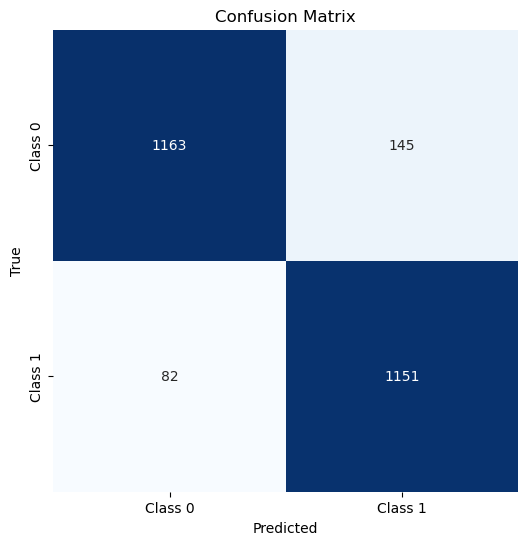

In [64]:
# Plot the confusion matrix using seaborn heatmap
cm = confusion_matrix(y_test, y_pred)

labels = ['Class 0', 'Class 1']

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

plt.show()
